### In this script, DBN has run and this script is used to make predictions; use successful pull only;
### in thie scrpt, prediction is done on session by session base
### In this script, DBN is run with 1s time bin, 3 time lag 
### In this script, the animal tracking is done with only one camera - camera 2 (middle) 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import scipy
import scipy.stats as st
import sklearn
from sklearn.neighbors import KernelDensity
import string
import warnings
import pickle

import os
import glob
import random
from time import time

from pgmpy.models import BayesianModel
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch,BicScore
from pgmpy.base import DAG
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

### function - get body part location for each pair of cameras

In [2]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair
from ana_functions.body_part_locs_singlecam import body_part_locs_singlecam

### function - align the two cameras

In [3]:
from ana_functions.camera_align import camera_align       

### function - merge the two pairs of cameras

In [4]:
from ana_functions.camera_merge import camera_merge

### function - find social gaze time point

In [5]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_singlecam import find_socialgaze_timepoint_singlecam
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody import find_socialgaze_timepoint_singlecam_wholebody

### function - define time point of behavioral events

In [6]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_singlecam import bhv_events_timepoint_singlecam

### function - plot behavioral events

In [7]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

### function - make demo videos with skeleton and inportant vectors

In [8]:
from ana_functions.tracking_video_singlecam_demo import tracking_video_singlecam_demo
from ana_functions.tracking_video_singlecam_wholebody_demo import tracking_video_singlecam_wholebody_demo

### function - interval between all behavioral events

In [9]:
from ana_functions.bhv_events_interval import bhv_events_interval
from ana_functions.bhv_events_interval import bhv_events_interval_certainEdges

### function - train the dynamic bayesian network - multi time lag (3 lags)

In [10]:
from ana_functions.train_DBN_multiLag import train_DBN_multiLag
from ana_functions.train_DBN_multiLag import train_DBN_multiLag_create_df_only
from ana_functions.train_DBN_multiLag import train_DBN_multiLag_training_only
from ana_functions.train_DBN_multiLag import graph_to_matrix
from ana_functions.train_DBN_multiLag import get_weighted_dags
from ana_functions.train_DBN_multiLag import get_significant_edges
from ana_functions.train_DBN_multiLag import threshold_edges
from ana_functions.train_DBN_multiLag import Modulation_Index
from ana_functions.EfficientTimeShuffling import EfficientShuffle
from ana_functions.AicScore import AicScore

## Analyze each session

### prepare the basic behavioral data (especially the time stamps for each bhv events)

In [11]:
# instead of using gaze angle threshold, use the target rectagon to deside gaze info
# ...need to update
sqr_thres_tubelever = 75 # draw the square around tube and lever
sqr_thres_face = 1.15 # a ratio for defining face boundary
sqr_thres_body = 4 # how many times to enlongate the face box boundry to the body


# get the fps of the analyzed video
fps = 30

# frame number of the demo video
# nframes = 0.5*30 # second*30fps
nframes = 2*30 # second*30fps

# re-analyze the video or not
reanalyze_video = 0
redo_anystep = 0

# session list options
do_bestsession = 1 # only analyze the best (five) sessions for each conditions during the training phase
do_trainedMCs = 1 # the list that only consider trained (1s) MC, together with SR and NV as controls
if do_bestsession:
    if not do_trainedMCs:
        savefile_sufix = '_bestsessions'
    elif do_trainedMCs:
        savefile_sufix = '_trainedMCsessions'
else:
    savefile_sufix = ''

# which camera to analyzed
cameraID = 'camera-2'
cameraID_short = 'cam2'

# where to save the summarizing data
data_saved_folder = '/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/3d_recontruction_analysis_self_and_coop_task_data_saved/'


    

### load the DBN related data for each dyad and run the prediction
### For each condition, only use the hypothetical dependencies

load all ROC data for hypothetical dependencies, and only plot the summary figure
load all ROC data for hypothetical dependencies, and only plot the summary figure
load all ROC data for hypothetical dependencies, and only plot the summary figure
load all ROC data for hypothetical dependencies, and only plot the summary figure
load all ROC data for hypothetical dependencies, and only plot the summary figure
load all ROC data for hypothetical dependencies, and only plot the summary figure


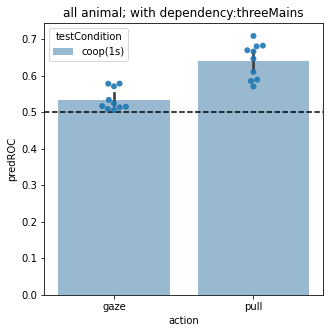

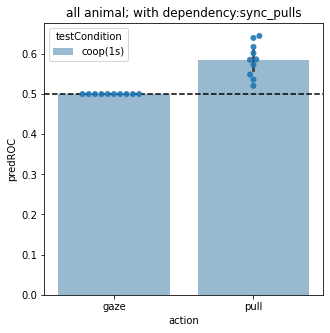

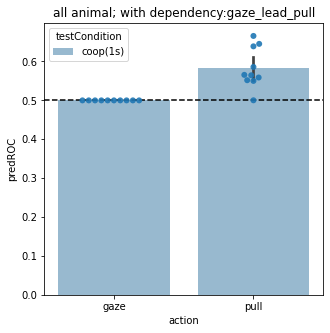

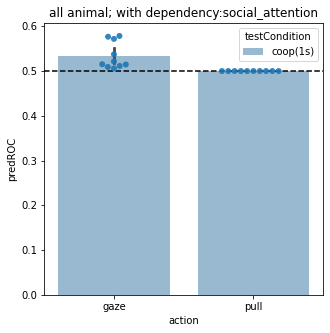

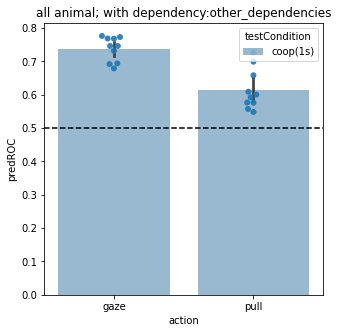

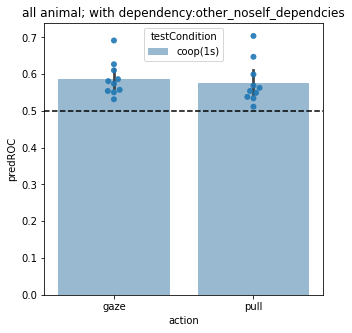

In [12]:
# Suppress all warnings
warnings.simplefilter('ignore')

redoFitting = 0

niters = 100

# PLOT multiple pairs in one plot, so need to load data seperately
moreSampSize = 0
mergetempRos = 0 # 1: merge different time bins

#
animal1_fixedorders = ['eddie','dodson','ginger','dannon','koala']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga','vermelho']
# animal1_fixedorders = ['eddie',]
# animal2_fixedorders = ['sparkle',]
nanimalpairs = np.shape(animal1_fixedorders)[0]

temp_resolu = 1

# ONLY FOR PLOT!! 
# define DBN related summarizing variables
# DBN_group_typenames = ['self','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
# DBN_group_typeIDs  =  [1,3,3,3,5]
# DBN_group_coopthres = [0,2,1.5,1,0]
DBN_group_typenames = ['coop(2s)']
DBN_group_typeIDs  =  [3,]
DBN_group_coopthres = [2,]
if do_trainedMCs:
    DBN_group_typenames = ['coop(1s)']
    DBN_group_typeIDs  =  [3]
    DBN_group_coopthres = [1]
nDBN_groups = np.shape(DBN_group_typenames)[0]

# DBN input data - to and from Nodes
toNodes = ['pull1_t3','pull2_t3','owgaze1_t3','owgaze2_t3']
fromNodes = ['pull1_t2','pull2_t2','owgaze1_t2','owgaze2_t2']
eventnames = ["M1pull","M2pull","M1gaze","M2gaze"]
nevents = np.shape(eventnames)[0]

timelagtype = '' # '' means 1secondlag, otherwise will be specificed
#
if timelagtype == '2secondlag':
    fromNodes = ['pull1_t1','pull2_t1','owgaze1_t1','owgaze2_t1']
if timelagtype == '3secondlag':
    fromNodes = ['pull1_t0','pull2_t0','owgaze1_t0','owgaze2_t0']

    
# hypothetical graph structure that reflect the strategies
# hypothetical graph structure that reflect the strategies
strategynames = ['threeMains','sync_pulls','gaze_lead_pull','social_attention',
                 'other_dependencies','other_noself_dependcies']
# strategynames = ['threeMains',]
# strategynames = ['gaze_lead_pull'] # ['all_threes','sync_pulls','gaze_lead_pull','social_attention']
bina_graphs_specific_strategy = {
    'threeMains': np.array([[0,1,0,1],[1,0,1,0],[1,0,0,0],[0,1,0,0]]),
    'sync_pulls': np.array([[0,1,0,0],[1,0,0,0],[0,0,0,0],[0,0,0,0]]),
    'gaze_lead_pull':np.array([[0,0,0,0],[0,0,0,0],[1,0,0,0],[0,1,0,0]]),
    'social_attention':np.array([[0,0,0,1],[0,0,1,0],[0,0,0,0],[0,0,0,0]]),
    'other_dependencies': np.array([[1,0,1,0],[0,1,0,1],[0,1,1,1],[1,0,1,1]]),
    'other_noself_dependcies': np.array([[0,0,1,0],[0,0,0,1],[0,1,0,1],[1,0,1,0]]),
}
nstrategies_forplot = np.shape(strategynames)[0]


for istrg in np.arange(0,nstrategies_forplot,1):
    
    strategyname = strategynames[istrg]

    #
    bina_graph_mean_strg = bina_graphs_specific_strategy[strategyname]
    
    # translate the binary DAGs to edge
    nrows,ncols = np.shape(bina_graph_mean_strg)
    edgenames = []
    for irow in np.arange(0,nrows,1):
        for icol in np.arange(0,ncols,1):
            if bina_graph_mean_strg[irow,icol] > 0:
                edgenames.append((fromNodes[irow],toNodes[icol]))

    # define the DBN predicting model
    bn = BayesianNetwork()
    bn.add_nodes_from(fromNodes)
    bn.add_nodes_from(toNodes)
    bn.add_edges_from(edgenames)
    
    effect_slice = toNodes
    
    # load ROC_summary_all data
    try:
        if redoFitting:
            dumpy
        
        print('load all ROC data for hypothetical dependencies, and only plot the summary figure')
        
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_allsessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'

        with open(data_saved_subfolder+'/ROC_summary_all_dependencies_'+strategyname+timelagtype+'.pkl', 'rb') as f:
            ROC_summary_all = pickle.load(f)
   
    except:  
    
        # initialize a summary dataframe for plotting the summary figure across animals 
        ROC_summary_all = pd.DataFrame(columns=['animal','action','testCondition','date','predROC'])

        fig, axs = plt.subplots(nanimalpairs,nDBN_groups) # nDBN_groups(3) task conditions; 2 animal individual
        fig.set_figheight(8*nanimalpairs)
        fig.set_figwidth(8*nDBN_groups)

        for ianimalpair in np.arange(0,nanimalpairs,1):

            # initiate figure
            # fig, axs = plt.subplots(nDBN_groups,2) # nDBN_groups(3) task conditions; 2 animal individual
            # fig.set_figheight(8*nDBN_groups)
            # fig.set_figwidth(15*2)

            # load the DBN input data
            animal1_fixedorder = animal1_fixedorders[ianimalpair]
            animal2_fixedorder = animal2_fixedorders[ianimalpair]
            
            # load the basic behavioral measures
            # load saved data
            data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
            #
            with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
                owgaze1_num_all_dates = pickle.load(f)
            with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
                owgaze2_num_all_dates = pickle.load(f)
            with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
                mtgaze1_num_all_dates = pickle.load(f)
            with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
                mtgaze2_num_all_dates = pickle.load(f)
            with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
                pull1_num_all_dates = pickle.load(f)
            with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
                pull2_num_all_dates = pickle.load(f)
            with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
                tasktypes_all_dates = pickle.load(f)
            with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
                coopthres_all_dates = pickle.load(f)
            with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
                succ_rate_all_dates = pickle.load(f)
            with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
                interpullintv_all_dates = pickle.load(f)
            with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
                trialnum_all_dates = pickle.load(f)
            with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
                bhv_intv_all_dates = pickle.load(f)
            
            # load the DBN input data (with successful pull only)
            data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_SuccAndFailedPull_newDefinition_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
            if not mergetempRos:
                with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder+animal2_fixedorder+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
                    DBN_input_data_alltypes = pickle.load(f)
            else:
                with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder+animal2_fixedorder+'_mergeTempsReSo.pkl', 'rb') as f:
                    DBN_input_data_alltypes = pickle.load(f)
                        #
            # load the DBN training outcome
            data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
            if moreSampSize:
                with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
                    weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
                    weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
                    sig_edges_diffTempRo_diffSampSize = pickle.load(f)
            else:
                with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
                    weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
                    weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
                with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
                    sig_edges_diffTempRo_diffSampSize = pickle.load(f)
                        

            # make sure these variables are the same as in the previous steps
            # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
            temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
            ntemp_reses = np.shape(temp_resolus)[0]
            #
            if moreSampSize:
                # different data (down/re)sampling numbers
                # samplingsizes = np.arange(1100,3000,100)
                samplingsizes = [1100]
                # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
                # samplingsizes = [100,500]
                # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
                samplingsizes_name = list(map(str, samplingsizes))
            else:
                samplingsizes_name = ['min_row_number']   
            nsamplings = np.shape(samplingsizes_name)[0]

            #
            temp_resolu = temp_resolus[0]
            j_sampsize_name = samplingsizes_name[0]    

            #
            # re-organize the target dates
            # 100: self; 3: 3s coop; 2: 2s coop; 1.5: 1.5s coop; 1: 1s coop; -1: no-vision
            tasktypes_all_dates[tasktypes_all_dates==5] = -1 # change the task type code for no-vision
            coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
            coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting

            #
            # sort the data based on task type and dates
            dates_list = list(DBN_input_data_alltypes['succpull'].keys())
            sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
            sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
            
            for igroup in np.arange(0,nDBN_groups,1):
                DBN_group_typename = DBN_group_typenames[igroup]
                
                if DBN_group_typename == 'coop(1s)':
                    #
                    # only select the targeted dates
                    # sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1)|(sorting_df['coopthres']==1.5)|(sorting_df['coopthres']==2)|(sorting_df['coopthres']==3)]
                    # sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1)|(sorting_df['coopthres']==1.5)|(sorting_df['coopthres']==2)]
                    # sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1)|(sorting_df['coopthres']==2)]        
                    sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1)]
                    # sorting_tgt_df = sorting_df
                if DBN_group_typename == 'coop(2s)':
                    sorting_tgt_df = sorting_df[(sorting_df['coopthres']==2)]
                dates_list_tgt = sorting_tgt_df['dates']
                dates_list_tgt = np.array(dates_list_tgt)
                #
                ndates_tgt = np.shape(dates_list_tgt)[0]
                
                weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][DBN_group_typename]
                weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][DBN_group_typename]
                # sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[('succpull',str(temp_resolu),j_sampsize_name)][DBN_group_typename]
                sig_edges_tgt = get_significant_edges(weighted_graphs_tgt,weighted_graphs_shuffled_tgt)
                
                # mean weight 
                weighted_graphs_mean_tgt = np.nanmean(weighted_graphs_tgt,axis=0)
                weighted_graphs_mean_tgt = weighted_graphs_mean_tgt * sig_edges_tgt

                bina_graphs_mean_tgt = sig_edges_tgt

                
                # do it for each date
                for idate in np.arange(0,ndates_tgt,1):
                    
                    datename = dates_list_tgt[idate]
                
                    DBN_input_data_tgt = DBN_input_data_alltypes['succpull'][datename]

                    # run niters iterations for each condition
                    for iiter in np.arange(0,niters,1):


                        # Split data into training and testing sets
                        train_data, test_data = train_test_split(DBN_input_data_tgt, test_size=0.2)
                        # test_data = DBN_input_data_tgt

                        # Perform parameter learning for each time slice
                        bn.fit(train_data, estimator=MaximumLikelihoodEstimator)

                        # Perform inference
                        infer = VariableElimination(bn)

                        # Prediction for each behavioral events
                        for ievent in np.arange(0,nevents,1):

                            var = effect_slice[ievent]
                            Pbehavior = [] # Initialize log-likelihood

                            for index, row in test_data.iterrows():
                                evidence = {fromNodes[0]: row[fromNodes[0]], 
                                            fromNodes[1]: row[fromNodes[1]], 
                                            fromNodes[2]: row[fromNodes[2]], 
                                            fromNodes[3]: row[fromNodes[3]], }

                                # Query the probability distribution for Pulls given evidence
                                try:
                                    aucPpredBehavior = infer.query(variables=[var], evidence=evidence) 
                                    # Extract the probability of outcome = 1
                                    prob = aucPpredBehavior.values[1]
                                except:
                                    prob = np.nan
                                Pbehavior = np.append(Pbehavior, prob)

                            # Calculate the AUC score
                            trueBeh = test_data[var].values
                            try:
                                auc = roc_auc_score(trueBeh, Pbehavior)
                            except:
                                auc = np.nan
                            print(f"AUC Score: {auc:.4f}")

                            # Optionally, plot the ROC curve - only plot for the first iteration
                            if iiter == 0:
                                ind_nan = np.isnan(Pbehavior)
                                Pbehavior = Pbehavior[~ind_nan]
                                trueBeh = trueBeh[~ind_nan]
                                fpr, tpr, _ = roc_curve(trueBeh, Pbehavior)
                                try:
                                    axs[ianimalpair,igroup].plot(fpr, tpr, 
                                                                 label=f'AUC for '+eventnames[ievent]+' auc = '+"{:.2f}".format(auc))
                                except:
                                    axs[ianimalpair].plot(fpr, tpr, 
                                                             label=f'AUC for '+eventnames[ievent]+' auc = '+"{:.2f}".format(auc))

                            # put data in the summarizing data frame
                            if (ievent == 0) | (ievent == 2): # for animal1
                                ROC_summary_all = ROC_summary_all.append({'animal':animal1_fixedorder,
                                                                          'action':eventnames[ievent][2:],
                                                                          'testCondition':DBN_group_typename,
                                                                          'date':datename,
                                                                          'predROC':auc
                                                                         }, ignore_index=True)
                            else:
                                ROC_summary_all = ROC_summary_all.append({'animal':animal2_fixedorder,
                                                                          'action':eventnames[ievent][2:],
                                                                          'testCondition':DBN_group_typename,
                                                                          'date':datename,
                                                                          'predROC':auc
                                                                     }, ignore_index=True)

                        if iiter == 0:
                            try:
                                axs[ianimalpair,igroup].plot([0, 1], [0, 1], 'k--')
                                axs[ianimalpair,igroup].set_xlabel('False Positive Rate')
                                axs[ianimalpair,igroup].set_ylabel('True Positive Rate')
                                axs[ianimalpair,igroup].set_title('ROC Curve '+animal1_fixedorder+'&'+animal2_fixedorder
                                                                  +'\n'+DBN_group_typename+'; with dependency:'+strategyname+timelagtype)
                                axs[ianimalpair,igroup].legend(loc='lower right')
                            except:
                                axs[ianimalpair].plot([0, 1], [0, 1], 'k--')
                                axs[ianimalpair].set_xlabel('False Positive Rate')
                                axs[ianimalpair].set_ylabel('True Positive Rate')
                                axs[ianimalpair].set_title('ROC Curve '+animal1_fixedorder+'&'+animal2_fixedorder
                                                                  +'\n'+DBN_group_typename+'; with dependency:'+strategyname+timelagtype)
                                axs[ianimalpair].legend(loc='lower right')

        savefig = 1
        if savefig:
            figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
            if not os.path.exists(figsavefolder):
                os.makedirs(figsavefolder)
            fig.savefig(figsavefolder+'withinCondition_DBNpredicition_fullDBN_binaryGraph_onlydependency'+strategyname+timelagtype+'.pdf')

        
        
        # save the summarizing data ROC_summary_all
        savedata = 1
        if savedata:
            data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_allsessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
            if not os.path.exists(data_saved_subfolder):
                os.makedirs(data_saved_subfolder)

            with open(data_saved_subfolder+'/ROC_summary_all_dependencies_'+strategyname+timelagtype+'.pkl', 'wb') as f:
                pickle.dump(ROC_summary_all, f)

            
            
    # average ROC across all iterations
    # separate Kanga into two groups based on her partner
    ROC_summary_all.iloc[np.where([ROC_summary_all['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all.iloc[np.where([ROC_summary_all['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
    #
    animals_ROC = np.unique(ROC_summary_all['animal'])
    nanis = np.shape(animals_ROC)[0]
    actions_ROC = np.unique(ROC_summary_all['action'])
    nacts = np.shape(actions_ROC)[0]
    testCons_ROC = np.unique(ROC_summary_all['testCondition'])
    ntcons = np.shape(testCons_ROC)[0]
    ROC_summary_all_mean = pd.DataFrame(columns=ROC_summary_all.keys())
    #
    for iani in np.arange(0,nanis,1):
        animal_ROC = animals_ROC[iani]
        ind_ani = ROC_summary_all['animal']==animal_ROC
        ROC_summary_all_iani = ROC_summary_all[ind_ani]
        #
        for iact in np.arange(0,nacts,1):
            action_ROC = actions_ROC[iact]
            ind_act = ROC_summary_all_iani['action']==action_ROC
            ROC_summary_all_iact = ROC_summary_all_iani[ind_act]
            #
            for itcon in np.arange(0,ntcons,1):
                testCon_ROC = testCons_ROC[itcon]
                ind_tcon = ROC_summary_all_iact['testCondition']==testCon_ROC
                ROC_summary_all_itcon = ROC_summary_all_iact[ind_tcon]
                #
                ROC_summary_all_mean = ROC_summary_all_mean.append({'animal':animal_ROC,
                                                                    'action':action_ROC,
                                                                    'testCondition':testCon_ROC,
                                                                    'predROC':np.nanmean(ROC_summary_all_itcon['predROC'])
                                                                     }, ignore_index=True)        
    
    # plot the summarizing figure
    fig2, axs2 = plt.subplots(1,1)
    fig2.set_figheight(5)
    fig2.set_figwidth(5)
    seaborn.barplot(ax=axs2,data=ROC_summary_all_mean,x='action',y='predROC',hue='testCondition',
                    errorbar='ci',alpha=.5)
    seaborn.swarmplot(ax=axs2,data=ROC_summary_all_mean,x='action',y='predROC',hue='testCondition',
                      alpha=.9,size=6,dodge=True,legend=False)
    plt.plot([-0.5,1.5],[0.5,0.5],'k--')
    axs2.set_xlim([-0.5,1.5])
    axs2.set_title('all animal'+'; with dependency:'+strategyname+timelagtype)

    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        fig2.savefig(figsavefolder+'withinCondition_DBNpredicition_fullDBN_binaryGraph_onlydependency'+strategyname+timelagtype+'_summarizingplot.pdf')

### plot the ROC across all analysis conditions
### only do this after all the previous analysis were done 

load all ROC data for hypothetical dependencies - three main dependencies
load all ROC data for hypothetical dependencies - sync_pulls
load all ROC data for hypothetical dependencies - gaze_lead_pull
load all ROC data for hypothetical dependencies - social_attention


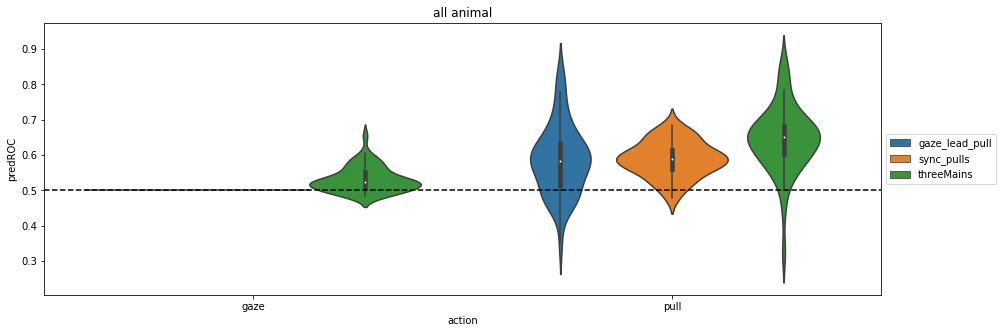

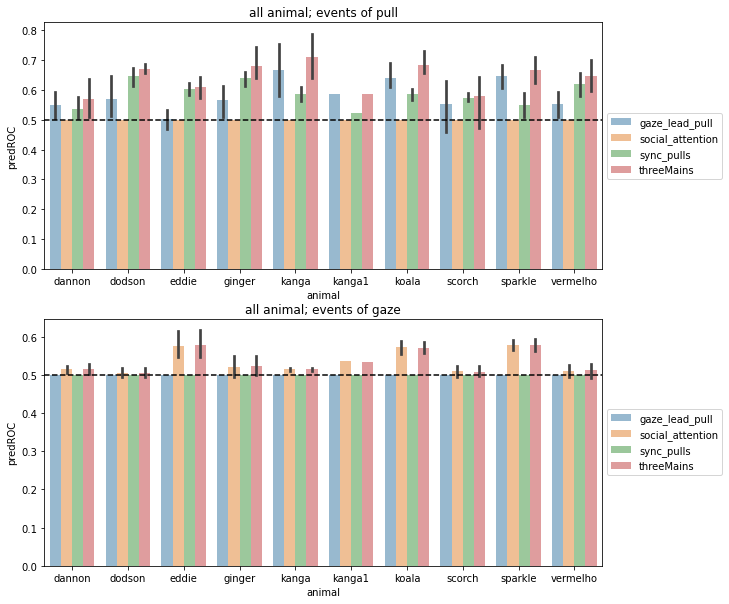

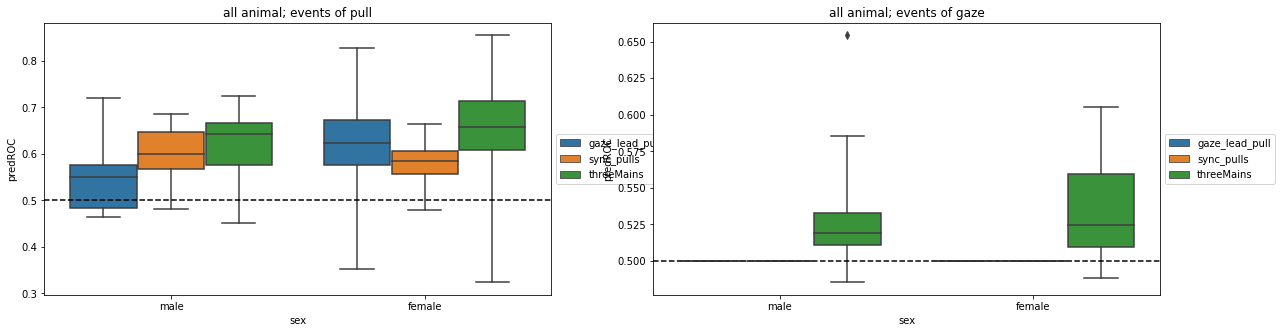

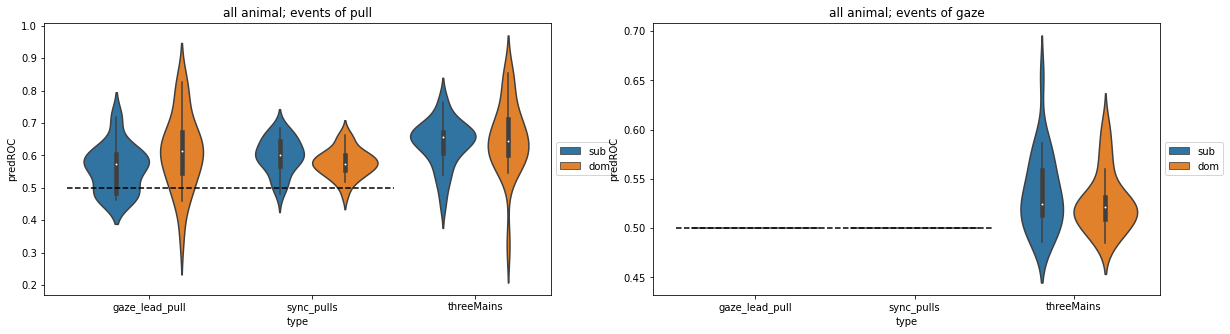

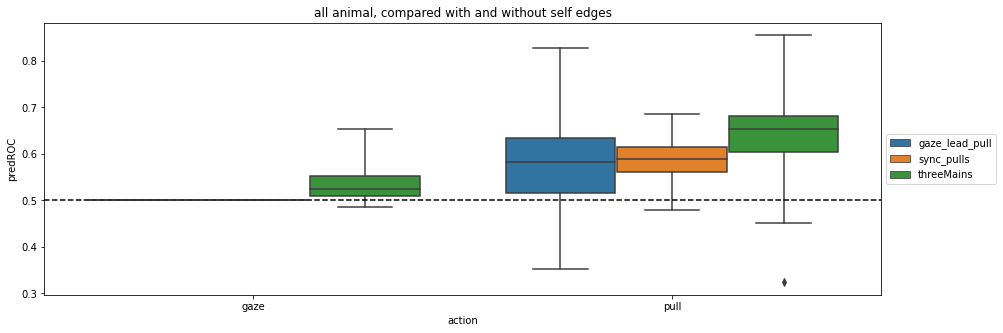

In [13]:
# DBN model information
timelagtype = 'allthreelags'

# load all the ROC_all data
#
print('load all ROC data for hypothetical dependencies - three main dependencies')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_allsessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_threeMains.pkl', 'rb') as f:
    ROC_summary_all_threeMains = pickle.load(f)
# separate Kanga into two groups based on her partner
ROC_summary_all_threeMains.iloc[np.where([ROC_summary_all_threeMains['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_threeMains.iloc[np.where([ROC_summary_all_threeMains['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
    
#
print('load all ROC data for hypothetical dependencies - sync_pulls')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_allsessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_sync_pulls.pkl', 'rb') as f:
    ROC_summary_all_sync_pulls = pickle.load(f)    
# separate Kanga into two groups based on her partner
ROC_summary_all_sync_pulls.iloc[np.where([ROC_summary_all_sync_pulls['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_sync_pulls.iloc[np.where([ROC_summary_all_sync_pulls['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
    
#
print('load all ROC data for hypothetical dependencies - gaze_lead_pull')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_allsessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_gaze_lead_pull.pkl', 'rb') as f:
    ROC_summary_all_gaze_lead_pull = pickle.load(f) 
# separate Kanga into two groups based on her partner
ROC_summary_all_gaze_lead_pull.iloc[np.where([ROC_summary_all_gaze_lead_pull['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_gaze_lead_pull.iloc[np.where([ROC_summary_all_gaze_lead_pull['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')

#
print('load all ROC data for hypothetical dependencies - social_attention')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_allsessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_social_attention.pkl', 'rb') as f:
    ROC_summary_all_social_attention = pickle.load(f) 
# separate Kanga into two groups based on her partner
ROC_summary_all_social_attention.iloc[np.where([ROC_summary_all_social_attention['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_social_attention.iloc[np.where([ROC_summary_all_social_attention['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
 
# put all data together
ROC_summary_all_threeMains['type']='threeMains'
ROC_summary_all_sync_pulls['type']='sync_pulls'
ROC_summary_all_gaze_lead_pull['type']='gaze_lead_pull'
ROC_summary_all_social_attention['type']='social_attention'
#
# 
ROC_summary_all_merged = pd.concat([
                                    ROC_summary_all_threeMains,
                                    ROC_summary_all_sync_pulls,
                                    ROC_summary_all_gaze_lead_pull,
                                    ROC_summary_all_social_attention,
                                    
                                   ])


# for each animal calculate the mean
#
animals_ROC = np.unique(ROC_summary_all_merged['animal'])
nanis = np.shape(animals_ROC)[0]
actions_ROC = np.unique(ROC_summary_all_merged['action'])
nacts = np.shape(actions_ROC)[0]
testCons_ROC = np.unique(ROC_summary_all_merged['testCondition'])
ntcons = np.shape(testCons_ROC)[0]
types_ROC = np.unique(ROC_summary_all_merged['type'])
ntypes = np.shape(types_ROC)[0]
ROC_summary_all_mean = pd.DataFrame(columns=ROC_summary_all_merged.keys())
#
for iani in np.arange(0,nanis,1):
    animal_ROC = animals_ROC[iani]
    ind_ani = ROC_summary_all_merged['animal']==animal_ROC
    ROC_summary_all_iani = ROC_summary_all_merged[ind_ani]
    #
    for iact in np.arange(0,nacts,1):
        action_ROC = actions_ROC[iact]
        ind_act = ROC_summary_all_iani['action']==action_ROC
        ROC_summary_all_iact = ROC_summary_all_iani[ind_act]
        #
        datenames_tgt = np.unique(ROC_summary_all_iact['date'])
        ndates = np.shape(datenames_tgt)[0]
        for idate in np.arange(0,ndates,1):
            datename_tgt = datenames_tgt[idate]
            ind_idate = ROC_summary_all_iact['date'] == datename_tgt
            ROC_summary_all_idate = ROC_summary_all_iact[ind_idate]
            #
            for itcon in np.arange(0,ntcons,1):
                testCon_ROC = testCons_ROC[itcon]
                ind_tcon = ROC_summary_all_idate['testCondition']==testCon_ROC
                ROC_summary_all_itcon = ROC_summary_all_idate[ind_tcon]
                #
                for itype in np.arange(0,ntypes,1):
                    type_ROC = types_ROC[itype]
                    ind_type = ROC_summary_all_itcon['type'] == type_ROC
                    ROC_summary_all_itype = ROC_summary_all_itcon[ind_type]
                    #
                    ROC_summary_all_mean = ROC_summary_all_mean.append({'animal':animal_ROC,
                                                                        'action':action_ROC,
                                                                        'testCondition':testCon_ROC,
                                                                        'type':type_ROC,
                                                                        'date':datename_tgt,
                                                                        'predROC':np.nanmean(ROC_summary_all_itype['predROC'])
                                                                     }, ignore_index=True)


# plot
testCond_forplot = 'coop(1s)' # 'no-vision','self','coop(1s)'
# ROC_summary_all_forplot = ROC_summary_all_merged[ROC_summary_all_merged['testCondition']==testCond_forplot]
ROC_summary_all_forplot = ROC_summary_all_mean[ROC_summary_all_mean['testCondition']==testCond_forplot]
#
plottypes = ['threeMains','sync_pulls','gaze_lead_pull',]
ind_toplot = np.isin(ROC_summary_all_forplot['type'],plottypes)
ROC_summary_all_forplot1 = ROC_summary_all_forplot[ind_toplot]
#
# plot the summarizing figure - pool all animals together
#
fig2, axs2 = plt.subplots(1,1)
fig2.set_figheight(5)
fig2.set_figwidth(15)
# s=seaborn.barplot(ax=axs2,data=ROC_summary_all_forplot,x='action',y='predROC',hue='type',errorbar='ci',alpha=.5)
# s=seaborn.boxplot(ax=axs2,data=ROC_summary_all_forplot1,x='action',y='predROC',hue='type',whis=3)
s=seaborn.violinplot(ax=axs2,data=ROC_summary_all_forplot1,x='action',y='predROC',hue='type',whis=3)
# s=seaborn.swarmplot(ax=axs2,data=ROC_summary_all_forplot,x='action',y='predROC',hue='type',
#                   alpha=.9,size=6,dodge=True,legend=False)
plt.plot([-0.5,1.5],[0.5,0.5],'k--')
axs2.set_xlim([-0.5,1.5])
axs2.set_title('all animal')
s.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# plot the summarizing figure - separate each animal
#
fig3, axs3 = plt.subplots(2,1)
fig3.set_figheight(10)
fig3.set_figwidth(10)
#
events_forplot = ['pull','gaze'] 
nevents = np.shape(events_forplot)[0]

for ievent in np.arange(0,nevents,1):
    ievent_forplot = events_forplot[ievent]
    
    ROC_summary_all_ievent = ROC_summary_all_forplot[ROC_summary_all_forplot['action']==ievent_forplot]
    #
    s=seaborn.barplot(ax=axs3[ievent],data=ROC_summary_all_ievent,x='animal',y='predROC',hue='type',
                    errorbar='ci',alpha=.5)
    # s=seaborn.boxplot(ax=axs3[ievent],data=ROC_summary_all_ievent,x='animal',y='predROC',hue='type')
    # s=seaborn.swarmplot(ax=axs3[ievent],data=ROC_summary_all_ievent,x='animal',y='predROC',hue='type',
    #                   alpha=.9,size=6,dodge=True,legend=False)
    axs3[ievent].plot([-0.5,9.5],[0.5,0.5],'k--')
    axs3[ievent].set_xlim([-0.5,9.5])
    axs3[ievent].set_title('all animal; events of '+ievent_forplot)
    s.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
# plot the summarizing figure - separate male and female
maleanimals = np.array(['eddie','dannon','dodson','vermelho'])
allanimalnames = np.array(ROC_summary_all_forplot['animal'])
allanimalsexes = allanimalnames.copy()
#
allanimalsexes[np.isin(allanimalnames,maleanimals)]='male'
allanimalsexes[~np.isin(allanimalnames,maleanimals)]='female'
#
ROC_summary_all_forplot['sex'] = allanimalsexes

plottypes = ['threeMains','sync_pulls','gaze_lead_pull',]
ind_toplot = np.isin(ROC_summary_all_forplot['type'],plottypes)
ROC_summary_all_forplot1 = ROC_summary_all_forplot[ind_toplot]
ROC_summary_all_forplot1_malefemale = ROC_summary_all_forplot1.copy()

#
fig4, axs4 = plt.subplots(1,2)
fig4.set_figheight(5)
fig4.set_figwidth(20)
#
events_forplot = ['pull','gaze'] 
nevents = np.shape(events_forplot)[0]

for ievent in np.arange(0,nevents,1):
    ievent_forplot = events_forplot[ievent]
    
    ROC_summary_all_ievent = ROC_summary_all_forplot1[ROC_summary_all_forplot1['action']==ievent_forplot]
    #
    # s=seaborn.barplot(ax=axs4[ievent],data=ROC_summary_all_ievent,x='sex',y='predROC',hue='type',
    #                 errorbar='ci',alpha=.5)
    s=seaborn.boxplot(ax=axs4[ievent],data=ROC_summary_all_ievent,x='sex',y='predROC',hue='type',whis=3)
    # s=seaborn.swarmplot(ax=axs3[ievent],data=ROC_summary_all_ievent,x='animal',y='predROC',hue='type',
    #                   alpha=.9,size=6,dodge=True,legend=False)
    axs4[ievent].plot([-0.5,1.5],[0.5,0.5],'k--')
    axs4[ievent].set_xlim([-0.5,1.5])
    axs4[ievent].set_title('all animal; events of '+ievent_forplot)
    s.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    

# plot the summarizing figure - separate sub and dom
subanimals = np.array(['eddie','dannon','dodson','ginger','koala'])
allanimalnames = np.array(ROC_summary_all_forplot['animal'])
allanimalhiers = allanimalnames.copy()
#
allanimalhiers[np.isin(allanimalnames,subanimals)]='sub'
allanimalhiers[~np.isin(allanimalnames,subanimals)]='dom'
#
ROC_summary_all_forplot['hier'] = allanimalhiers

plottypes = ['threeMains','sync_pulls','gaze_lead_pull',]
ind_toplot = np.isin(ROC_summary_all_forplot['type'],plottypes)
ROC_summary_all_forplot1 = ROC_summary_all_forplot[ind_toplot]
ROC_summary_all_forplot1_subdom = ROC_summary_all_forplot1.copy()

#
fig6, axs6 = plt.subplots(1,2)
fig6.set_figheight(5)
fig6.set_figwidth(20)
#
events_forplot = ['pull','gaze'] 
nevents = np.shape(events_forplot)[0]

for ievent in np.arange(0,nevents,1):
    ievent_forplot = events_forplot[ievent]
    
    ROC_summary_all_ievent = ROC_summary_all_forplot1[ROC_summary_all_forplot1['action']==ievent_forplot]
    #
    # s=seaborn.barplot(ax=axs4[ievent],data=ROC_summary_all_ievent,x='sex',y='predROC',hue='type',
    #                 errorbar='ci',alpha=.5)
    s=seaborn.violinplot(ax=axs6[ievent],data=ROC_summary_all_ievent,
                         x='type',y='predROC',hue='hier',whis=3)
    # s=seaborn.swarmplot(ax=axs6[ievent],data=ROC_summary_all_ievent,x='type',y='predROC',hue='hier',
    #                   alpha=.9,size=6,dodge=True,legend=False)
    axs6[ievent].plot([-0.5,1.5],[0.5,0.5],'k--')
    # axs6[ievent].set_xlim([-0.5,1.5])
    axs6[ievent].set_title('all animal; events of '+ievent_forplot)
    s.legend(loc='center left', bbox_to_anchor=(1, 0.5))   

# plot the summarizing figure - only plot the speficified condition; plot all animals together
fig5, axs5 = plt.subplots(1,1)
fig5.set_figheight(5)
fig5.set_figwidth(15)
#
testCond_forplot = 'coop(1s)' # 'no-vision','self','coop(1s)'
# ROC_summary_all_forplot = ROC_summary_all_merged[ROC_summary_all_merged['testCondition']==testCond_forplot]
ROC_summary_all_forplot = ROC_summary_all_mean[ROC_summary_all_mean['testCondition']==testCond_forplot]
#
plottypes = ['threeMains','sync_pulls','gaze_lead_pull']
ind_toplot = np.isin(ROC_summary_all_forplot['type'],plottypes)
ROC_summary_all_forplot2 = ROC_summary_all_forplot[ind_toplot]

# s=seaborn.barplot(ax=axs5,data=ROC_summary_all_forplot2,x='action',y='predROC',hue='type',errorbar='ci',alpha=.5)
s=seaborn.boxplot(ax=axs5,data=ROC_summary_all_forplot2,x='action',y='predROC',hue='type',whis=3)
# s=seaborn.swarmplot(ax=axs5,data=ROC_summary_all_forplot2,x='action',y='predROC',hue='type',
#                   alpha=.9,size=6,dodge=True,legend=False)
plt.plot([-0.5,1.5],[0.5,0.5],'k--')
axs5.set_xlim([-0.5,1.5])
axs5.set_title('all animal, compared with and without self edges')
s.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
savefig = 1
if savefig:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    fig2.savefig(figsavefolder+'withinCondition_DBNpredicition_'+timelagtype+'DBN_andHypotheticalDependencies_'+testCond_forplot+'_summarizingplot_allanimals.pdf')
    fig3.savefig(figsavefolder+'withinCondition_DBNpredicition_'+timelagtype+'DBN_andHypotheticalDependencies_'+testCond_forplot+'_summarizingplot_eachanimals.pdf')
    fig4.savefig(figsavefolder+'withinCondition_DBNpredicition_'+timelagtype+'DBN_andHypotheticalDependencies_'+testCond_forplot+'_summarizingplot_malefemales.pdf')
    fig5.savefig(figsavefolder+'withinCondition_DBNpredicition_'+timelagtype+'DBN_andHypotheticalDependencies_'+testCond_forplot+'_summarizingplot_allanimals_withandwithoutselfedge.pdf')
    fig6.savefig(figsavefolder+'withinCondition_DBNpredicition_'+timelagtype+'DBN_andHypotheticalDependencies_'+testCond_forplot+'_summarizingplot_subdoms.pdf')



In [14]:
ROC_summary_all_forplot2

,animal,action,testCondition,date,predROC,type
0,dannon,gaze,coop(1s),20231030,0.500000,gaze_lead_pull
2,dannon,gaze,coop(1s),20231030,0.500000,sync_pulls
3,dannon,gaze,coop(1s),20231030,0.488127,threeMains
4,dannon,gaze,coop(1s),20231031,0.500000,gaze_lead_pull
6,dannon,gaze,coop(1s),20231031,0.500000,sync_pulls
...,...,...,...,...,...,...
394,vermelho,pull,coop(1s),20240223,0.569556,sync_pulls
395,vermelho,pull,coop(1s),20240223,0.573362,threeMains
396,vermelho,pull,coop(1s),20240226,0.573129,gaze_lead_pull
398,vermelho,pull,coop(1s),20240226,0.588333,sync_pulls


In [15]:
if 1:
    plottypes = ['threeMains','sync_pulls','gaze_lead_pull',]
    ind_toplot = np.isin(ROC_summary_all_forplot['type'],plottypes)
    ROC_summary_all_forplot1 = ROC_summary_all_forplot[ind_toplot]
    # ROC_summary_all_forplot1

    # perform the anova on all animals
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    
    df_long2 = ROC_summary_all_forplot1[ROC_summary_all_forplot1['action']=='pull']

    # anova
    cw_lm=ols('predROC 	 ~ type', data=df_long2).fit() #Specify C for Categorical
    print(sm.stats.anova_lm(cw_lm, typ=2))

    # post hoc test 
    tukey = pairwise_tukeyhsd(endog=df_long2['predROC'], groups=df_long2['type'], alpha=0.05)
    print(tukey)

    # ttest or wilcoxon
    # print(st.wilcoxon(np.array(df_long2[df_long2['type']=='sync_pulls']['predROC'])-0.5))
    
    # print(st.wilcoxon(np.array(df_long2[df_long2['type']=='gaze_lead_pull']['predROC'])-0.5))
    print(st.wilcoxon(np.array(df_long2[df_long2['type']=='threeMains']['predROC'])-0.5))

            sum_sq     df         F    PR(>F)
type      0.111783    2.0  8.224031  0.000412
Residual  0.999030  147.0       NaN       NaN
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
    group1       group2   meandiff p-adj   lower  upper  reject
---------------------------------------------------------------
gaze_lead_pull sync_pulls   0.0017    0.9 -0.0374 0.0407  False
gaze_lead_pull threeMains   0.0587 0.0014  0.0197 0.0978   True
    sync_pulls threeMains   0.0571  0.002   0.018 0.0961   True
---------------------------------------------------------------
WilcoxonResult(statistic=41.0, pvalue=8.502529682098662e-09)


In [16]:
data = ROC_summary_all_forplot1[(ROC_summary_all_forplot1['type']=='binary_afterMI_noself')&(ROC_summary_all_forplot1['action']=='gaze')]
data = data['predROC']
print(np.nanmean(data))
print(np.nanstd(data))


nan
nan


In [17]:
if 1:
    # perform the anova on all animals
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    
    df_long2 = ROC_summary_all_forplot1_malefemale[ROC_summary_all_forplot1_malefemale['action']=='pull']

    # anova
    cw_lm=ols('predROC 	 ~ type+sex', data=df_long2).fit() #Specify C for Categorical
    print(sm.stats.anova_lm(cw_lm, typ=2))

    # post hoc test 
    tukey = pairwise_tukeyhsd(endog=df_long2['predROC'], groups=df_long2['type']+df_long2['sex'], alpha=0.05)
    print(tukey)

    # ttest or wilcoxon
    # print(st.wilcoxon(np.array(df_long2[df_long2['type']=='sync_pulls']['predROC'])-0.5))
    
    # print(st.wilcoxon(np.array(df_long2[df_long2['type']=='gaze_lead_pull']['predROC'])-0.5))
    print(st.wilcoxon(np.array(df_long2[df_long2['type']=='threeMains']['predROC'])-0.5))

            sum_sq     df         F    PR(>F)
type      0.111783    2.0  8.497906  0.000323
sex       0.038774    1.0  5.895362  0.016397
Residual  0.960256  146.0       NaN       NaN
             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1              group2       meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------
gaze_lead_pullfemale gaze_lead_pullmale  -0.0742 0.0173 -0.1399 -0.0084   True
gaze_lead_pullfemale   sync_pullsfemale  -0.0363 0.5058 -0.0966  0.0239  False
gaze_lead_pullfemale     sync_pullsmale  -0.0201    0.9 -0.0858  0.0457  False
gaze_lead_pullfemale   threeMainsfemale   0.0443 0.2816  -0.016  0.1046  False
gaze_lead_pullfemale     threeMainsmale   0.0045    0.9 -0.0613  0.0702  False
  gaze_lead_pullmale   sync_pullsfemale   0.0378 0.5513 -0.0279  0.1036  False
  gaze_lead_pullmale     sync_pullsmale   0.0541 0.2411 -0.0167   0.125  False
  gaze_lead_pullmale   thr

In [18]:
if 1:
    # perform the anova on all animals
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    
    df_long2 = ROC_summary_all_forplot1_subdom[ROC_summary_all_forplot1_subdom['action']=='pull']

    # anova
    cw_lm=ols('predROC 	 ~ type+hier', data=df_long2).fit() #Specify C for Categorical
    print(sm.stats.anova_lm(cw_lm, typ=2))

    # post hoc test 
    tukey = pairwise_tukeyhsd(endog=df_long2['predROC'], groups=df_long2['type']+df_long2['hier'], alpha=0.05)
    print(tukey)

    # ttest or wilcoxon
    # print(st.wilcoxon(np.array(df_long2[df_long2['type']=='sync_pulls']['predROC'])-0.5))
    
    # print(st.wilcoxon(np.array(df_long2[df_long2['type']=='gaze_lead_pull']['predROC'])-0.5))
    print(st.wilcoxon(np.array(df_long2[df_long2['type']=='threeMains']['predROC'])-0.5))

            sum_sq     df         F    PR(>F)
type      0.111783    2.0  8.240038  0.000407
hier      0.008724    1.0  1.286114  0.258624
Residual  0.990306  146.0       NaN       NaN
           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
      group1            group2      meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------
gaze_lead_pulldom gaze_lead_pullsub  -0.0516 0.2262 -0.1182 0.0149  False
gaze_lead_pulldom     sync_pullsdom  -0.0353  0.626 -0.1019 0.0313  False
gaze_lead_pulldom     sync_pullssub   -0.013    0.9 -0.0796 0.0535  False
gaze_lead_pulldom     threeMainsdom   0.0411 0.4808 -0.0255 0.1077  False
gaze_lead_pulldom     threeMainssub   0.0247 0.8878 -0.0419 0.0913  False
gaze_lead_pullsub     sync_pullsdom   0.0163    0.9 -0.0502 0.0829  False
gaze_lead_pullsub     sync_pullssub   0.0386  0.544  -0.028 0.1052  False
gaze_lead_pullsub     threeMainsdom   0.0927 0.0013  0.0261 0.1593   True
ga

In [19]:
ind1 = (ROC_summary_all_forplot1_subdom['action']=='pull')&\
       (ROC_summary_all_forplot1_subdom['hier']=='sub')&\
       (ROC_summary_all_forplot1_subdom['type']=='gaze_lead_pull')
ind2 = (ROC_summary_all_forplot1_subdom['action']=='pull')&\
       (ROC_summary_all_forplot1_subdom['hier']=='dom')&\
       (ROC_summary_all_forplot1_subdom['type']=='gaze_lead_pull')
xxx1 = ROC_summary_all_forplot1_subdom[ind1]['predROC']
xxx2 = ROC_summary_all_forplot1_subdom[ind2]['predROC']
t_stat, p_value = st.mannwhitneyu(xxx1, xxx2, alternative='two-sided')
# t_stat, p_value = st.ttest_rel(xxx1, xxx2, alternative='two-sided')
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

t-statistic: 208.0000
p-value: 0.0436


In [20]:
ROC_summary_all_forplot1_subdom

,animal,action,testCondition,date,predROC,type,sex,hier
0,dannon,gaze,coop(1s),20231030,0.500000,gaze_lead_pull,male,sub
2,dannon,gaze,coop(1s),20231030,0.500000,sync_pulls,male,sub
3,dannon,gaze,coop(1s),20231030,0.488127,threeMains,male,sub
4,dannon,gaze,coop(1s),20231031,0.500000,gaze_lead_pull,male,sub
6,dannon,gaze,coop(1s),20231031,0.500000,sync_pulls,male,sub
...,...,...,...,...,...,...,...,...
394,vermelho,pull,coop(1s),20240223,0.569556,sync_pulls,male,dom
395,vermelho,pull,coop(1s),20240223,0.573362,threeMains,male,dom
396,vermelho,pull,coop(1s),20240226,0.573129,gaze_lead_pull,male,dom
398,vermelho,pull,coop(1s),20240226,0.588333,sync_pulls,male,dom


In [21]:
st.wxxx1

AttributeError: module 'scipy.stats' has no attribute 'wxxx1'

In [22]:
xxx2

204    0.545390
208    0.460346
212    0.509912
216    0.759812
220    0.819197
224    0.827670
228    0.649327
232    0.779239
236    0.640607
244    0.586007
304    0.470538
308    0.627683
312    0.580565
316    0.352671
320    0.637652
324    0.642457
348    0.696824
352    0.673808
356    0.589489
360    0.589871
364    0.676703
384    0.531258
388    0.613944
392    0.489221
396    0.573129
Name: predROC, dtype: float64

### plot the ROC comparing MC anf L2
### only do this after all the previous analysis were done 

load all ROC data for hypothetical dependencies - three main dependencies
load all ROC data for hypothetical dependencies - sync_pulls
load all ROC data for hypothetical dependencies - gaze_lead_pull
load all ROC data for hypothetical dependencies - social_attention
load all ROC data for hypothetical dependencies - three main dependencies
load all ROC data for hypothetical dependencies - sync_pulls
load all ROC data for hypothetical dependencies - gaze_lead_pull
load all ROC data for hypothetical dependencies - social_attention


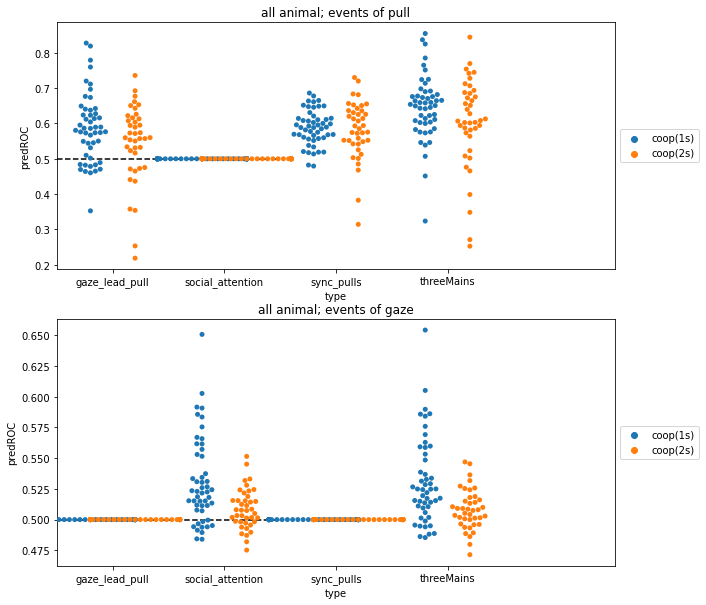

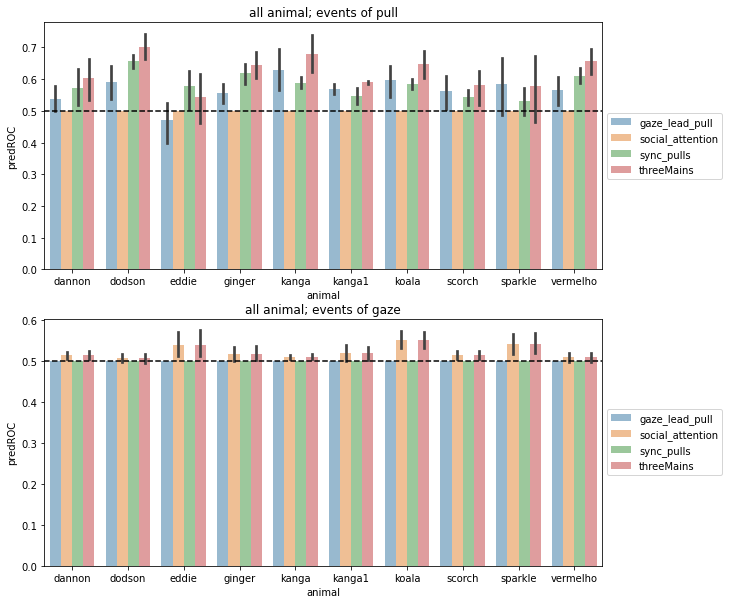

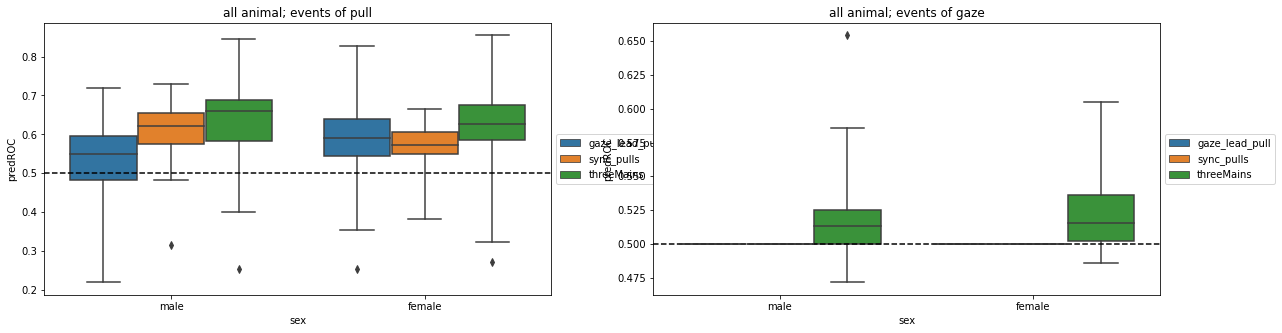

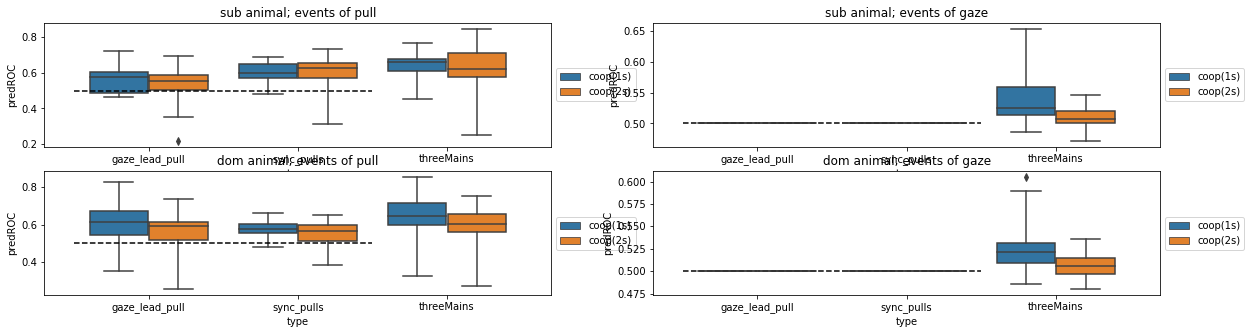

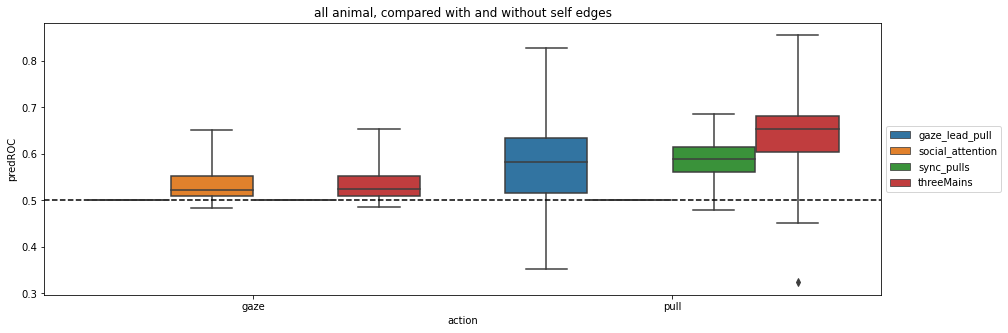

In [23]:
# DBN model information
timelagtype = 'allthreelags'

# load all the ROC_all data
    
# load L2 data files
savefile_sufix = '_bestsessions'
#
print('load all ROC data for hypothetical dependencies - three main dependencies')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_allsessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_threeMains.pkl', 'rb') as f:
    ROC_summary_all_threeMains = pickle.load(f)
# separate Kanga into two groups based on her partner
ROC_summary_all_threeMains.iloc[np.where([ROC_summary_all_threeMains['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_threeMains.iloc[np.where([ROC_summary_all_threeMains['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
ROC_summary_all_threeMains_L2 = ROC_summary_all_threeMains.copy()    
    
#
print('load all ROC data for hypothetical dependencies - sync_pulls')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_allsessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_sync_pulls.pkl', 'rb') as f:
    ROC_summary_all_sync_pulls = pickle.load(f)    
# separate Kanga into two groups based on her partner
ROC_summary_all_sync_pulls.iloc[np.where([ROC_summary_all_sync_pulls['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_sync_pulls.iloc[np.where([ROC_summary_all_sync_pulls['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
ROC_summary_all_sync_pulls_L2 = ROC_summary_all_sync_pulls.copy()

#
print('load all ROC data for hypothetical dependencies - gaze_lead_pull')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_allsessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_gaze_lead_pull.pkl', 'rb') as f:
    ROC_summary_all_gaze_lead_pull = pickle.load(f) 
# separate Kanga into two groups based on her partner
ROC_summary_all_gaze_lead_pull.iloc[np.where([ROC_summary_all_gaze_lead_pull['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_gaze_lead_pull.iloc[np.where([ROC_summary_all_gaze_lead_pull['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
ROC_summary_all_gaze_lead_pull_L2 = ROC_summary_all_gaze_lead_pull.copy()

#
print('load all ROC data for hypothetical dependencies - social_attention')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_allsessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_social_attention.pkl', 'rb') as f:
    ROC_summary_all_social_attention = pickle.load(f) 
# separate Kanga into two groups based on her partner
ROC_summary_all_social_attention.iloc[np.where([ROC_summary_all_social_attention['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_social_attention.iloc[np.where([ROC_summary_all_social_attention['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
ROC_summary_all_social_attention_L2 = ROC_summary_all_social_attention.copy()

# load MC data files
savefile_sufix = '_trainedMCsessions'
#
print('load all ROC data for hypothetical dependencies - three main dependencies')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_allsessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_threeMains.pkl', 'rb') as f:
    ROC_summary_all_threeMains = pickle.load(f)
# separate Kanga into two groups based on her partner
ROC_summary_all_threeMains.iloc[np.where([ROC_summary_all_threeMains['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_threeMains.iloc[np.where([ROC_summary_all_threeMains['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
ROC_summary_all_threeMains_MC = ROC_summary_all_threeMains.copy()    
    
#
print('load all ROC data for hypothetical dependencies - sync_pulls')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_allsessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_sync_pulls.pkl', 'rb') as f:
    ROC_summary_all_sync_pulls = pickle.load(f)    
# separate Kanga into two groups based on her partner
ROC_summary_all_sync_pulls.iloc[np.where([ROC_summary_all_sync_pulls['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_sync_pulls.iloc[np.where([ROC_summary_all_sync_pulls['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
ROC_summary_all_sync_pulls_MC = ROC_summary_all_sync_pulls.copy()

#
print('load all ROC data for hypothetical dependencies - gaze_lead_pull')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_allsessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_gaze_lead_pull.pkl', 'rb') as f:
    ROC_summary_all_gaze_lead_pull = pickle.load(f) 
# separate Kanga into two groups based on her partner
ROC_summary_all_gaze_lead_pull.iloc[np.where([ROC_summary_all_gaze_lead_pull['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_gaze_lead_pull.iloc[np.where([ROC_summary_all_gaze_lead_pull['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
ROC_summary_all_gaze_lead_pull_MC = ROC_summary_all_gaze_lead_pull.copy()

#
print('load all ROC data for hypothetical dependencies - social_attention')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_allsessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_social_attention.pkl', 'rb') as f:
    ROC_summary_all_social_attention = pickle.load(f) 
# separate Kanga into two groups based on her partner
ROC_summary_all_social_attention.iloc[np.where([ROC_summary_all_social_attention['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_social_attention.iloc[np.where([ROC_summary_all_social_attention['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
ROC_summary_all_social_attention_MC = ROC_summary_all_social_attention.copy()
    
    
# put all data together
ROC_summary_all_threeMains_L2['type']='threeMains'
ROC_summary_all_sync_pulls_L2['type']='sync_pulls'
ROC_summary_all_gaze_lead_pull_L2['type']='gaze_lead_pull'
ROC_summary_all_social_attention_L2['type']='social_attention'
#
ROC_summary_all_threeMains_MC['type']='threeMains'
ROC_summary_all_sync_pulls_MC['type']='sync_pulls'
ROC_summary_all_gaze_lead_pull_MC['type']='gaze_lead_pull'
ROC_summary_all_social_attention_MC['type']='social_attention'

# 
ROC_summary_all_merged = pd.concat([
                                    ROC_summary_all_threeMains_L2,
                                    ROC_summary_all_sync_pulls_L2,
                                    ROC_summary_all_gaze_lead_pull_L2,
                                    ROC_summary_all_social_attention_L2,
                                    #
                                    ROC_summary_all_threeMains_MC,
                                    ROC_summary_all_sync_pulls_MC,
                                    ROC_summary_all_gaze_lead_pull_MC,
                                    ROC_summary_all_social_attention_MC,
                                   ])


# for each animal calculate the mean
#
animals_ROC = np.unique(ROC_summary_all_merged['animal'])
nanis = np.shape(animals_ROC)[0]
actions_ROC = np.unique(ROC_summary_all_merged['action'])
nacts = np.shape(actions_ROC)[0]
testCons_ROC = np.unique(ROC_summary_all_merged['testCondition'])
ntcons = np.shape(testCons_ROC)[0]
types_ROC = np.unique(ROC_summary_all_merged['type'])
ntypes = np.shape(types_ROC)[0]
ROC_summary_all_mean = pd.DataFrame(columns=ROC_summary_all_merged.keys())
#
for iani in np.arange(0,nanis,1):
    animal_ROC = animals_ROC[iani]
    ind_ani = ROC_summary_all_merged['animal']==animal_ROC
    ROC_summary_all_iani = ROC_summary_all_merged[ind_ani]
    #
    for iact in np.arange(0,nacts,1):
        action_ROC = actions_ROC[iact]
        ind_act = ROC_summary_all_iani['action']==action_ROC
        ROC_summary_all_iact = ROC_summary_all_iani[ind_act]
        #
        datenames_tgt = np.unique(ROC_summary_all_iact['date'])
        ndates = np.shape(datenames_tgt)[0]
        for idate in np.arange(0,ndates,1):
            datename_tgt = datenames_tgt[idate]
            ind_idate = ROC_summary_all_iact['date'] == datename_tgt
            ROC_summary_all_idate = ROC_summary_all_iact[ind_idate]
            #
            for itcon in np.arange(0,ntcons,1):
                testCon_ROC = testCons_ROC[itcon]
                ind_tcon = ROC_summary_all_idate['testCondition']==testCon_ROC
                ROC_summary_all_itcon = ROC_summary_all_idate[ind_tcon]
                #
                for itype in np.arange(0,ntypes,1):
                    type_ROC = types_ROC[itype]
                    ind_type = ROC_summary_all_itcon['type'] == type_ROC
                    ROC_summary_all_itype = ROC_summary_all_itcon[ind_type]
                    #
                    ROC_summary_all_mean = ROC_summary_all_mean.append({'animal':animal_ROC,
                                                                        'action':action_ROC,
                                                                        'testCondition':testCon_ROC,
                                                                        'type':type_ROC,
                                                                        'date':datename_tgt,
                                                                        'predROC':np.nanmean(ROC_summary_all_itype['predROC'])
                                                                     }, ignore_index=True)

# plot
# testCond_forplot = 'coop(1s)' # 'no-vision','self','coop(1s)'
# ROC_summary_all_forplot = ROC_summary_all_merged[ROC_summary_all_merged['testCondition']==testCond_forplot]
# ROC_summary_all_forplot = ROC_summary_all_mean[ROC_summary_all_mean['testCondition']==testCond_forplot]
ROC_summary_all_forplot = ROC_summary_all_mean
#
plottypes = ['threeMains','sync_pulls','gaze_lead_pull',]
ind_toplot = np.isin(ROC_summary_all_forplot['type'],plottypes)
ROC_summary_all_forplot1 = ROC_summary_all_forplot[ind_toplot]
#
# plot the summarizing figure - pool all animals together
#
fig2, axs2 = plt.subplots(2,1)
fig2.set_figheight(10)
fig2.set_figwidth(10)
#
events_forplot = ['pull','gaze'] 
nevents = np.shape(events_forplot)[0]

for ievent in np.arange(0,nevents,1):
    ievent_forplot = events_forplot[ievent]
    
    ROC_summary_all_ievent = ROC_summary_all_forplot[ROC_summary_all_forplot['action']==ievent_forplot]
    #
    # s=seaborn.boxplot(ax=axs2[ievent],data=ROC_summary_all_ievent,x='type',y='predROC',hue='testCondition',whis=3)
    s=seaborn.swarmplot(ax=axs2[ievent],data=ROC_summary_all_ievent,x='type',y='predROC',hue='testCondition',
                       dodge = True)
    axs2[ievent].plot([-0.5,1.5],[0.5,0.5],'k--')
    axs2[ievent].set_xlim([-0.5,4.5])
    axs2[ievent].set_title('all animal; events of '+ievent_forplot)
    s.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plot the summarizing figure - separate each animal
#
fig3, axs3 = plt.subplots(2,1)
fig3.set_figheight(10)
fig3.set_figwidth(10)
#
events_forplot = ['pull','gaze'] 
nevents = np.shape(events_forplot)[0]

for ievent in np.arange(0,nevents,1):
    ievent_forplot = events_forplot[ievent]
    
    ROC_summary_all_ievent = ROC_summary_all_forplot[ROC_summary_all_forplot['action']==ievent_forplot]
    #
    s=seaborn.barplot(ax=axs3[ievent],data=ROC_summary_all_ievent,x='animal',y='predROC',hue='type',
                    errorbar='ci',alpha=.5)
    # s=seaborn.boxplot(ax=axs3[ievent],data=ROC_summary_all_ievent,x='animal',y='predROC',hue='type')
    # s=seaborn.swarmplot(ax=axs3[ievent],data=ROC_summary_all_ievent,x='animal',y='predROC',hue='type',
    #                   alpha=.9,size=6,dodge=True,legend=False)
    axs3[ievent].plot([-0.5,9.5],[0.5,0.5],'k--')
    axs3[ievent].set_xlim([-0.5,9.5])
    axs3[ievent].set_title('all animal; events of '+ievent_forplot)
    s.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
# plot the summarizing figure - separate male and female
maleanimals = np.array(['eddie','dannon','dodson','vermelho'])
allanimalnames = np.array(ROC_summary_all_forplot['animal'])
allanimalsexes = allanimalnames.copy()
#
allanimalsexes[np.isin(allanimalnames,maleanimals)]='male'
allanimalsexes[~np.isin(allanimalnames,maleanimals)]='female'
#
ROC_summary_all_forplot['sex'] = allanimalsexes

plottypes = ['binary_afterMI_noself','threeMains','sync_pulls','gaze_lead_pull',]
ind_toplot = np.isin(ROC_summary_all_forplot['type'],plottypes)
ROC_summary_all_forplot1 = ROC_summary_all_forplot[ind_toplot]
ROC_summary_all_forplot1_malefemale = ROC_summary_all_forplot1.copy()

#
fig4, axs4 = plt.subplots(1,2)
fig4.set_figheight(5)
fig4.set_figwidth(20)
#
events_forplot = ['pull','gaze'] 
nevents = np.shape(events_forplot)[0]

for ievent in np.arange(0,nevents,1):
    ievent_forplot = events_forplot[ievent]
    
    ROC_summary_all_ievent = ROC_summary_all_forplot1[ROC_summary_all_forplot1['action']==ievent_forplot]
    #
    # s=seaborn.barplot(ax=axs4[ievent],data=ROC_summary_all_ievent,x='sex',y='predROC',hue='type',
    #                 errorbar='ci',alpha=.5)
    s=seaborn.boxplot(ax=axs4[ievent],data=ROC_summary_all_ievent,x='sex',y='predROC',hue='type',whis=3)
    # s=seaborn.swarmplot(ax=axs3[ievent],data=ROC_summary_all_ievent,x='animal',y='predROC',hue='type',
    #                   alpha=.9,size=6,dodge=True,legend=False)
    axs4[ievent].plot([-0.5,1.5],[0.5,0.5],'k--')
    axs4[ievent].set_xlim([-0.5,1.5])
    axs4[ievent].set_title('all animal; events of '+ievent_forplot)
    s.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    

# plot the summarizing figure - separate sub and dom
subanimals = np.array(['eddie','dannon','dodson','ginger','koala'])
allanimalnames = np.array(ROC_summary_all_forplot['animal'])
allanimalhiers = allanimalnames.copy()
#
allanimalhiers[np.isin(allanimalnames,subanimals)]='sub'
allanimalhiers[~np.isin(allanimalnames,subanimals)]='dom'
#
ROC_summary_all_forplot['hier'] = allanimalhiers

plottypes = ['binary_afterMI_noself','threeMains','sync_pulls','gaze_lead_pull',]
ind_toplot = np.isin(ROC_summary_all_forplot['type'],plottypes)
ROC_summary_all_forplot1 = ROC_summary_all_forplot[ind_toplot]
ROC_summary_all_forplot1_subdom = ROC_summary_all_forplot1.copy()

#
fig6, axs6 = plt.subplots(2,2)
fig6.set_figheight(5)
fig6.set_figwidth(20)
#
events_forplot = ['pull','gaze'] 
nevents = np.shape(events_forplot)[0]
#
hiers_forplot = ['sub','dom']
nhiers = np.shape(hiers_forplot)[0]

for ievent in np.arange(0,nevents,1):
    ievent_forplot = events_forplot[ievent]
    
    ROC_summary_all_ievent = ROC_summary_all_forplot1[ROC_summary_all_forplot1['action']==ievent_forplot]
    
    for ihier in np.arange(0,nhiers,1):
        
        ihier_forplot = hiers_forplot[ihier]
        
        ROC_summary_all_ihier = ROC_summary_all_ievent[ROC_summary_all_ievent['hier']==ihier_forplot]
        
        #
        # s=seaborn.barplot(ax=axs4[ihier,ievent],data=ROC_summary_all_ievent,x='sex',y='predROC',hue='type',
        #                 errorbar='ci',alpha=.5)
        s=seaborn.boxplot(ax=axs6[ihier,ievent],data=ROC_summary_all_ihier,
                             x='type',y='predROC',hue='testCondition',whis=3)
        # s=seaborn.swarmplot(ax=axs3[ihier,ievent],data=ROC_summary_all_ievent,x='animal',y='predROC',hue='type',
        #                   alpha=.9,size=6,dodge=True,legend=False)
        axs6[ihier,ievent].plot([-0.5,1.5],[0.5,0.5],'k--')
        # axs6[ievent].set_xlim([-0.5,1.5])
        axs6[ihier,ievent].set_title(ihier_forplot+' animal; events of '+ievent_forplot)
        s.legend(loc='center left', bbox_to_anchor=(1, 0.5))   
        

# plot the summarizing figure - only plot the speficified condition; plot all animals together
fig5, axs5 = plt.subplots(1,1)
fig5.set_figheight(5)
fig5.set_figwidth(15)
#
testCond_forplot = 'coop(1s)' # 'no-vision','self','coop(1s)'
# ROC_summary_all_forplot = ROC_summary_all_merged[ROC_summary_all_merged['testCondition']==testCond_forplot]
ROC_summary_all_forplot = ROC_summary_all_mean[ROC_summary_all_mean['testCondition']==testCond_forplot]
#
plottypes = ['threeMains','sync_pulls','gaze_lead_pull','social_attention',
    'threeMains_withSelfEdge','sync_pulls_withSelfEdge','gaze_lead_pull_withSelfEdge','social_attention_withSelfEdge']
ind_toplot = np.isin(ROC_summary_all_forplot['type'],plottypes)
ROC_summary_all_forplot2 = ROC_summary_all_forplot[ind_toplot]

# s=seaborn.barplot(ax=axs5,data=ROC_summary_all_forplot2,x='action',y='predROC',hue='type',errorbar='ci',alpha=.5)
s=seaborn.boxplot(ax=axs5,data=ROC_summary_all_forplot2,x='action',y='predROC',hue='type',whis=3)
# s=seaborn.swarmplot(ax=axs5,data=ROC_summary_all_forplot2,x='action',y='predROC',hue='type',
#                   alpha=.9,size=6,dodge=True,legend=False)
plt.plot([-0.5,1.5],[0.5,0.5],'k--')
axs5.set_xlim([-0.5,1.5])
axs5.set_title('all animal, compared with and without self edges')
s.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
savefig = 0
if savefig:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    fig2.savefig(figsavefolder+'withinCondition_DBNpredicition_'+timelagtype+'DBN_andHypotheticalDependencies_'+testCond_forplot+'_summarizingplot_allanimals.pdf')
    fig3.savefig(figsavefolder+'withinCondition_DBNpredicition_'+timelagtype+'DBN_andHypotheticalDependencies_'+testCond_forplot+'_summarizingplot_eachanimals.pdf')
    fig4.savefig(figsavefolder+'withinCondition_DBNpredicition_'+timelagtype+'DBN_andHypotheticalDependencies_'+testCond_forplot+'_summarizingplot_malefemales.pdf')
    fig5.savefig(figsavefolder+'withinCondition_DBNpredicition_'+timelagtype+'DBN_andHypotheticalDependencies_'+testCond_forplot+'_summarizingplot_allanimals_withandwithoutselfedge.pdf')
    fig6.savefig(figsavefolder+'withinCondition_DBNpredicition_'+timelagtype+'DBN_andHypotheticalDependencies_'+testCond_forplot+'_summarizingplot_subdoms.pdf')



In [24]:
ROC_summary_all_threeMains

,animal,action,testCondition,date,predROC
0,eddie,pull,coop(1s),20230410,0.621076
1,sparkle,pull,coop(1s),20230410,0.827273
2,eddie,gaze,coop(1s),20230410,0.544223
3,sparkle,gaze,coop(1s),20230410,0.526931
4,eddie,pull,coop(1s),20230410,0.475897
...,...,...,...,...,...
9995,vermelho,gaze,coop(1s),20240226,0.558895
9996,koala,pull,coop(1s),20240226,0.703963
9997,vermelho,pull,coop(1s),20240226,0.677121
9998,koala,gaze,coop(1s),20240226,0.535211


### plot the ROC across all analysis conditions
### only do this after all the previous analysis were done 
#### compare 1s 2s and 3s time lags (different timelagtype)

In [25]:
# load all the ROC_all data

# 1s time lags 
timelagtype = '1secondlag'

print('load all ROC data for 1secondlag within task condition (weighted dependencies with self dependencies)')
#
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_fullDBNdependencies_weighted_'+timelagtype+'.pkl', 'rb') as f:
    ROC_summary_all_full_weighted_1secondlag = pickle.load(f)
# separate Kanga into two groups based on her partner
ROC_summary_all_full_weighted_1secondlag.iloc[np.where([ROC_summary_all_full_weighted_1secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_full_weighted_1secondlag.iloc[np.where([ROC_summary_all_full_weighted_1secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')

#
print('load all ROC data for 1secondlag within task condition (weighted dependencies without self dependencies)')
#
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_fullDBNdependencies_weighted_noself_'+timelagtype+'.pkl', 'rb') as f:
    ROC_summary_all_full_weighted_noself_1secondlag = pickle.load(f)
# separate Kanga into two groups based on her partner
ROC_summary_all_full_weighted_noself_1secondlag.iloc[np.where([ROC_summary_all_full_weighted_noself_1secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_full_weighted_noself_1secondlag.iloc[np.where([ROC_summary_all_full_weighted_noself_1secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')

#
print('load all ROC data for 1secondlag hypothetical dependencies - three main dependencies')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_threeMains.pkl', 'rb') as f:
    ROC_summary_all_threeMains_1secondlag = pickle.load(f)
# separate Kanga into two groups based on her partner
ROC_summary_all_threeMains_1secondlag.iloc[np.where([ROC_summary_all_threeMains_1secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_threeMains_1secondlag.iloc[np.where([ROC_summary_all_threeMains_1secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
    
#
print('load all ROC data for 1secondlag hypothetical dependencies - sync_pulls')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_sync_pulls.pkl', 'rb') as f:
    ROC_summary_all_sync_pulls_1secondlag = pickle.load(f)    
# separate Kanga into two groups based on her partner
ROC_summary_all_sync_pulls_1secondlag.iloc[np.where([ROC_summary_all_sync_pulls_1secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_sync_pulls_1secondlag.iloc[np.where([ROC_summary_all_sync_pulls_1secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
    
#
print('load all ROC data for 1secondlag hypothetical dependencies - gaze_lead_pull')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_gaze_lead_pull.pkl', 'rb') as f:
    ROC_summary_all_gaze_lead_pull_1secondlag = pickle.load(f) 
# separate Kanga into two groups based on her partner
ROC_summary_all_gaze_lead_pull_1secondlag.iloc[np.where([ROC_summary_all_gaze_lead_pull_1secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_gaze_lead_pull_1secondlag.iloc[np.where([ROC_summary_all_gaze_lead_pull_1secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')

#
print('load all ROC data for 1secondlag hypothetical dependencies - social_attention')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_social_attention.pkl', 'rb') as f:
    ROC_summary_all_social_attention_1secondlag = pickle.load(f) 
# separate Kanga into two groups based on her partner
ROC_summary_all_social_attention_1secondlag.iloc[np.where([ROC_summary_all_social_attention_1secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_social_attention_1secondlag.iloc[np.where([ROC_summary_all_social_attention_1secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
    
#
print('load all ROC data for 1secondlag hypothetical dependencies - three main dependencies with Self Edge')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_threeMains_withSelfEdge.pkl', 'rb') as f:
    ROC_summary_all_threeMains_withSelfEdge_1secondlag = pickle.load(f)
# separate Kanga into two groups based on her partner
ROC_summary_all_threeMains_withSelfEdge_1secondlag.iloc[np.where([ROC_summary_all_threeMains_withSelfEdge_1secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_threeMains_withSelfEdge_1secondlag.iloc[np.where([ROC_summary_all_threeMains_withSelfEdge_1secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
    
#
print('load all ROC data for 1secondlag hypothetical dependencies - sync_pulls with Self Edge')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_sync_pulls_withSelfEdge.pkl', 'rb') as f:
    ROC_summary_all_sync_pulls_withSelfEdge_1secondlag = pickle.load(f)    
# separate Kanga into two groups based on her partner
ROC_summary_all_sync_pulls_withSelfEdge_1secondlag.iloc[np.where([ROC_summary_all_sync_pulls_withSelfEdge_1secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_sync_pulls_withSelfEdge_1secondlag.iloc[np.where([ROC_summary_all_sync_pulls_withSelfEdge_1secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
    
#
print('load all ROC data for 1secondlag hypothetical dependencies - gaze_lead_pull with Self Edge')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_gaze_lead_pull_withSelfEdge.pkl', 'rb') as f:
    ROC_summary_all_gaze_lead_pull_withSelfEdge_1secondlag = pickle.load(f) 
# separate Kanga into two groups based on her partner
ROC_summary_all_gaze_lead_pull_withSelfEdge_1secondlag.iloc[np.where([ROC_summary_all_gaze_lead_pull_withSelfEdge_1secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_gaze_lead_pull_withSelfEdge_1secondlag.iloc[np.where([ROC_summary_all_gaze_lead_pull_withSelfEdge_1secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')

#
print('load all ROC data for 2secondlag hypothetical dependencies - social_attention with Self Edge')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_social_attention_withSelfEdge.pkl', 'rb') as f:
    ROC_summary_all_social_attention_withSelfEdge_1secondlag = pickle.load(f) 
# separate Kanga into two groups based on her partner
ROC_summary_all_social_attention_withSelfEdge_1secondlag.iloc[np.where([ROC_summary_all_social_attention_withSelfEdge_1secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_social_attention_withSelfEdge_1secondlag.iloc[np.where([ROC_summary_all_social_attention_withSelfEdge_1secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
        

# 2s time lags 
timelagtype = '2secondlag'

print('load all ROC data for 2secondlag within task condition (weighted dependencies with self dependencies)')
#
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_fullDBNdependencies_weighted_'+timelagtype+'.pkl', 'rb') as f:
    ROC_summary_all_full_weighted_2secondlag = pickle.load(f)
# separate Kanga into two groups based on her partner
ROC_summary_all_full_weighted_2secondlag.iloc[np.where([ROC_summary_all_full_weighted_2secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_full_weighted_2secondlag.iloc[np.where([ROC_summary_all_full_weighted_2secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')

#
print('load all ROC data for 2secondlag within task condition (weighted dependencies without self dependencies)')
#
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_fullDBNdependencies_weighted_noself_'+timelagtype+'.pkl', 'rb') as f:
    ROC_summary_all_full_weighted_noself_2secondlag = pickle.load(f)
# separate Kanga into two groups based on her partner
ROC_summary_all_full_weighted_noself_2secondlag.iloc[np.where([ROC_summary_all_full_weighted_noself_2secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_full_weighted_noself_2secondlag.iloc[np.where([ROC_summary_all_full_weighted_noself_2secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')

#
print('load all ROC data for 2secondlag hypothetical dependencies - three main dependencies')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_threeMains'+timelagtype+'.pkl', 'rb') as f:
    ROC_summary_all_threeMains_2secondlag = pickle.load(f)
# separate Kanga into two groups based on her partner
ROC_summary_all_threeMains_2secondlag.iloc[np.where([ROC_summary_all_threeMains_2secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_threeMains_2secondlag.iloc[np.where([ROC_summary_all_threeMains_2secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
    
#
print('load all ROC data for 2secondlag hypothetical dependencies - sync_pulls')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_sync_pulls'+timelagtype+'.pkl', 'rb') as f:
    ROC_summary_all_sync_pulls_2secondlag = pickle.load(f)    
# separate Kanga into two groups based on her partner
ROC_summary_all_sync_pulls_2secondlag.iloc[np.where([ROC_summary_all_sync_pulls_2secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_sync_pulls_2secondlag.iloc[np.where([ROC_summary_all_sync_pulls_2secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
    
#
print('load all ROC data for 2secondlag hypothetical dependencies - gaze_lead_pull')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_gaze_lead_pull'+timelagtype+'.pkl', 'rb') as f:
    ROC_summary_all_gaze_lead_pull_2secondlag = pickle.load(f) 
# separate Kanga into two groups based on her partner
ROC_summary_all_gaze_lead_pull_2secondlag.iloc[np.where([ROC_summary_all_gaze_lead_pull_2secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_gaze_lead_pull_2secondlag.iloc[np.where([ROC_summary_all_gaze_lead_pull_2secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')

#
print('load all ROC data for 2secondlag hypothetical dependencies - social_attention')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_social_attention'+timelagtype+'.pkl', 'rb') as f:
    ROC_summary_all_social_attention_2secondlag = pickle.load(f) 
# separate Kanga into two groups based on her partner
ROC_summary_all_social_attention_2secondlag.iloc[np.where([ROC_summary_all_social_attention_2secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_social_attention_2secondlag.iloc[np.where([ROC_summary_all_social_attention_2secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
    
#
print('load all ROC data for 2secondlag hypothetical dependencies - three main dependencies with Self Edge')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_threeMains'+timelagtype+'_withSelfEdge.pkl', 'rb') as f:
    ROC_summary_all_threeMains_withSelfEdge_2secondlag = pickle.load(f)
# separate Kanga into two groups based on her partner
ROC_summary_all_threeMains_withSelfEdge_2secondlag.iloc[np.where([ROC_summary_all_threeMains_withSelfEdge_2secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_threeMains_withSelfEdge_2secondlag.iloc[np.where([ROC_summary_all_threeMains_withSelfEdge_2secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
    
#
print('load all ROC data for 2secondlag hypothetical dependencies - sync_pulls with Self Edge')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_sync_pulls'+timelagtype+'_withSelfEdge.pkl', 'rb') as f:
    ROC_summary_all_sync_pulls_withSelfEdge_2secondlag = pickle.load(f)    
# separate Kanga into two groups based on her partner
ROC_summary_all_sync_pulls_withSelfEdge_2secondlag.iloc[np.where([ROC_summary_all_sync_pulls_withSelfEdge_2secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_sync_pulls_withSelfEdge_2secondlag.iloc[np.where([ROC_summary_all_sync_pulls_withSelfEdge_2secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
    
#
print('load all ROC data for 2secondlag hypothetical dependencies - gaze_lead_pull with Self Edge')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_gaze_lead_pull'+timelagtype+'_withSelfEdge.pkl', 'rb') as f:
    ROC_summary_all_gaze_lead_pull_withSelfEdge_2secondlag = pickle.load(f) 
# separate Kanga into two groups based on her partner
ROC_summary_all_gaze_lead_pull_withSelfEdge_2secondlag.iloc[np.where([ROC_summary_all_gaze_lead_pull_withSelfEdge_2secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_gaze_lead_pull_withSelfEdge_2secondlag.iloc[np.where([ROC_summary_all_gaze_lead_pull_withSelfEdge_2secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')

#
print('load all ROC data for 2secondlag hypothetical dependencies - social_attention with Self Edge')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_social_attention'+timelagtype+'_withSelfEdge.pkl', 'rb') as f:
    ROC_summary_all_social_attention_withSelfEdge_2secondlag = pickle.load(f) 
# separate Kanga into two groups based on her partner
ROC_summary_all_social_attention_withSelfEdge_2secondlag.iloc[np.where([ROC_summary_all_social_attention_withSelfEdge_2secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_social_attention_withSelfEdge_2secondlag.iloc[np.where([ROC_summary_all_social_attention_withSelfEdge_2secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')


# 3s time lags 
timelagtype = '3secondlag'

print('load all ROC data for 3secondlag within task condition (weighted dependencies with self dependencies)')
#
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_fullDBNdependencies_weighted_'+timelagtype+'.pkl', 'rb') as f:
    ROC_summary_all_full_weighted_3secondlag = pickle.load(f)
# separate Kanga into two groups based on her partner
ROC_summary_all_full_weighted_3secondlag.iloc[np.where([ROC_summary_all_full_weighted_3secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_full_weighted_3secondlag.iloc[np.where([ROC_summary_all_full_weighted_3secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')

#
print('load all ROC data for 3secondlag within task condition (weighted dependencies without self dependencies)')
#
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_fullDBNdependencies_weighted_noself_'+timelagtype+'.pkl', 'rb') as f:
    ROC_summary_all_full_weighted_noself_3secondlag = pickle.load(f)
# separate Kanga into two groups based on her partner
ROC_summary_all_full_weighted_noself_3secondlag.iloc[np.where([ROC_summary_all_full_weighted_noself_3secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_full_weighted_noself_3secondlag.iloc[np.where([ROC_summary_all_full_weighted_noself_3secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')

#
print('load all ROC data for 3secondlag hypothetical dependencies - three main dependencies')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_threeMains'+timelagtype+'.pkl', 'rb') as f:
    ROC_summary_all_threeMains_3secondlag = pickle.load(f)
# separate Kanga into two groups based on her partner
ROC_summary_all_threeMains_3secondlag.iloc[np.where([ROC_summary_all_threeMains_3secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_threeMains_3secondlag.iloc[np.where([ROC_summary_all_threeMains_3secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
    
#
print('load all ROC data for 3secondlag hypothetical dependencies - sync_pulls')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_sync_pulls'+timelagtype+'.pkl', 'rb') as f:
    ROC_summary_all_sync_pulls_3secondlag = pickle.load(f)    
# separate Kanga into two groups based on her partner
ROC_summary_all_sync_pulls_3secondlag.iloc[np.where([ROC_summary_all_sync_pulls_3secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_sync_pulls_3secondlag.iloc[np.where([ROC_summary_all_sync_pulls_3secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
    
#
print('load all ROC data for 3secondlag hypothetical dependencies - gaze_lead_pull')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_gaze_lead_pull'+timelagtype+'.pkl', 'rb') as f:
    ROC_summary_all_gaze_lead_pull_3secondlag = pickle.load(f) 
# separate Kanga into two groups based on her partner
ROC_summary_all_gaze_lead_pull_3secondlag.iloc[np.where([ROC_summary_all_gaze_lead_pull_3secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_gaze_lead_pull_3secondlag.iloc[np.where([ROC_summary_all_gaze_lead_pull_3secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')

#
print('load all ROC data for 3secondlag hypothetical dependencies - social_attention')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_social_attention'+timelagtype+'.pkl', 'rb') as f:
    ROC_summary_all_social_attention_3secondlag = pickle.load(f) 
# separate Kanga into two groups based on her partner
ROC_summary_all_social_attention_3secondlag.iloc[np.where([ROC_summary_all_social_attention_3secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_social_attention_3secondlag.iloc[np.where([ROC_summary_all_social_attention_3secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
    
#
print('load all ROC data for 3secondlag hypothetical dependencies - three main dependencies with Self Edge')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_threeMains'+timelagtype+'_withSelfEdge.pkl', 'rb') as f:
    ROC_summary_all_threeMains_withSelfEdge_3secondlag = pickle.load(f)
# separate Kanga into two groups based on her partner
ROC_summary_all_threeMains_withSelfEdge_3secondlag.iloc[np.where([ROC_summary_all_threeMains_withSelfEdge_3secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_threeMains_withSelfEdge_3secondlag.iloc[np.where([ROC_summary_all_threeMains_withSelfEdge_3secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
    
#
print('load all ROC data for 3secondlag hypothetical dependencies - sync_pulls with Self Edge')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_sync_pulls'+timelagtype+'_withSelfEdge.pkl', 'rb') as f:
    ROC_summary_all_sync_pulls_withSelfEdge_3secondlag = pickle.load(f)    
# separate Kanga into two groups based on her partner
ROC_summary_all_sync_pulls_withSelfEdge_3secondlag.iloc[np.where([ROC_summary_all_sync_pulls_withSelfEdge_3secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_sync_pulls_withSelfEdge_3secondlag.iloc[np.where([ROC_summary_all_sync_pulls_withSelfEdge_3secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')
    
#
print('load all ROC data for 3secondlag hypothetical dependencies - gaze_lead_pull with Self Edge')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_gaze_lead_pull'+timelagtype+'_withSelfEdge.pkl', 'rb') as f:
    ROC_summary_all_gaze_lead_pull_withSelfEdge_3secondlag = pickle.load(f) 
# separate Kanga into two groups based on her partner
ROC_summary_all_gaze_lead_pull_withSelfEdge_3secondlag.iloc[np.where([ROC_summary_all_gaze_lead_pull_withSelfEdge_3secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_gaze_lead_pull_withSelfEdge_3secondlag.iloc[np.where([ROC_summary_all_gaze_lead_pull_withSelfEdge_3secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')

#
print('load all ROC data for 3secondlag hypothetical dependencies - social_attention with Self Edge')
#        
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
with open(data_saved_subfolder+'/ROC_summary_all_dependencies_social_attention'+timelagtype+'_withSelfEdge.pkl', 'rb') as f:
    ROC_summary_all_social_attention_withSelfEdge_3secondlag = pickle.load(f) 
# separate Kanga into two groups based on her partner
ROC_summary_all_social_attention_withSelfEdge_3secondlag.iloc[np.where([ROC_summary_all_social_attention_withSelfEdge_3secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]] = ROC_summary_all_social_attention_withSelfEdge_3secondlag.iloc[np.where([ROC_summary_all_social_attention_withSelfEdge_3secondlag['animal']=='kanga'])[1][0:niters*nDBN_groups*2]].replace('kanga','kanga1')





load all ROC data for 1secondlag within task condition (weighted dependencies with self dependencies)


FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/3d_recontruction_analysis_self_and_coop_task_data_saved/data_saved_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/_trainedMCsessions/camera-2//ROC_summary_all_dependencies_fullDBNdependencies_weighted_1secondlag.pkl'

In [26]:
# put all data together
ROC_summary_all_full_weighted_1secondlag['type']='weighted_1secondlag'
ROC_summary_all_full_weighted_noself_1secondlag['type']='weighted_noself_1secondlag'
ROC_summary_all_threeMains_1secondlag['type']='threeMains_1secondlag'
ROC_summary_all_sync_pulls_1secondlag['type']='sync_pulls_1secondlag'
ROC_summary_all_gaze_lead_pull_1secondlag['type']='gaze_lead_pull_1secondlag'
ROC_summary_all_social_attention_1secondlag['type']='social_attention_1secondlag'
ROC_summary_all_threeMains_withSelfEdge_1secondlag['type']='threeMains_withSelfEdge_1secondlag'
ROC_summary_all_sync_pulls_withSelfEdge_1secondlag['type']='sync_pulls_withSelfEdge_1secondlag'
ROC_summary_all_gaze_lead_pull_withSelfEdge_1secondlag['type']='gaze_lead_pull_withSelfEdge_1secondlag'
ROC_summary_all_social_attention_withSelfEdge_1secondlag['type']='social_attention_withSelfEdge_1secondlag'
#
ROC_summary_all_full_weighted_2secondlag['type']='weighted_2secondlag'
ROC_summary_all_full_weighted_noself_2secondlag['type']='weighted_noself_2secondlag'
ROC_summary_all_threeMains_2secondlag['type']='threeMains_2secondlag'
ROC_summary_all_sync_pulls_2secondlag['type']='sync_pulls_2secondlag'
ROC_summary_all_gaze_lead_pull_2secondlag['type']='gaze_lead_pull_2secondlag'
ROC_summary_all_social_attention_2secondlag['type']='social_attention_2secondlag'
ROC_summary_all_threeMains_withSelfEdge_2secondlag['type']='threeMains_withSelfEdge_2secondlag'
ROC_summary_all_sync_pulls_withSelfEdge_2secondlag['type']='sync_pulls_withSelfEdge_2secondlag'
ROC_summary_all_gaze_lead_pull_withSelfEdge_2secondlag['type']='gaze_lead_pull_withSelfEdge_2secondlag'
ROC_summary_all_social_attention_withSelfEdge_2secondlag['type']='social_attention_withSelfEdge_2secondlag'
#
ROC_summary_all_full_weighted_3secondlag['type']='weighted_3secondlag'
ROC_summary_all_full_weighted_noself_3secondlag['type']='weighted_noself_3secondlag'
ROC_summary_all_threeMains_3secondlag['type']='threeMains_3secondlag'
ROC_summary_all_sync_pulls_3secondlag['type']='sync_pulls_3secondlag'
ROC_summary_all_gaze_lead_pull_3secondlag['type']='gaze_lead_pull_3secondlag'
ROC_summary_all_social_attention_3secondlag['type']='social_attention_3secondlag'
ROC_summary_all_threeMains_withSelfEdge_3secondlag['type']='threeMains_withSelfEdge_3secondlag'
ROC_summary_all_sync_pulls_withSelfEdge_3secondlag['type']='sync_pulls_withSelfEdge_3secondlag'
ROC_summary_all_gaze_lead_pull_withSelfEdge_3secondlag['type']='gaze_lead_pull_withSelfEdge_3secondlag'
ROC_summary_all_social_attention_withSelfEdge_3secondlag['type']='social_attention_withSelfEdge_3secondlag'


#
ROC_summary_all_merged = pd.concat([
                                    ROC_summary_all_full_weighted_1secondlag,
                                    ROC_summary_all_full_weighted_noself_1secondlag,
                                    ROC_summary_all_threeMains_1secondlag,
                                    ROC_summary_all_sync_pulls_1secondlag,
                                    ROC_summary_all_gaze_lead_pull_1secondlag,
                                    ROC_summary_all_social_attention_1secondlag,
                                    ROC_summary_all_threeMains_withSelfEdge_1secondlag,
                                    ROC_summary_all_sync_pulls_withSelfEdge_1secondlag,
                                    ROC_summary_all_gaze_lead_pull_withSelfEdge_1secondlag,
                                    ROC_summary_all_social_attention_withSelfEdge_1secondlag,
                                    #
                                    ROC_summary_all_full_weighted_2secondlag,
                                    ROC_summary_all_full_weighted_noself_2secondlag,
                                    ROC_summary_all_threeMains_2secondlag,
                                    ROC_summary_all_sync_pulls_2secondlag,
                                    ROC_summary_all_gaze_lead_pull_2secondlag,
                                    ROC_summary_all_social_attention_2secondlag,
                                    ROC_summary_all_threeMains_withSelfEdge_2secondlag,
                                    ROC_summary_all_sync_pulls_withSelfEdge_2secondlag,
                                    ROC_summary_all_gaze_lead_pull_withSelfEdge_2secondlag,
                                    ROC_summary_all_social_attention_withSelfEdge_2secondlag,
                                    #
                                    ROC_summary_all_full_weighted_3secondlag,
                                    ROC_summary_all_full_weighted_noself_3secondlag,
                                    ROC_summary_all_threeMains_3secondlag,
                                    ROC_summary_all_sync_pulls_3secondlag,
                                    ROC_summary_all_gaze_lead_pull_3secondlag,
                                    ROC_summary_all_social_attention_3secondlag,
                                    ROC_summary_all_threeMains_withSelfEdge_3secondlag,
                                    ROC_summary_all_sync_pulls_withSelfEdge_3secondlag,
                                    ROC_summary_all_gaze_lead_pull_withSelfEdge_3secondlag,
                                    ROC_summary_all_social_attention_withSelfEdge_3secondlag,
                                   ])


NameError: name 'ROC_summary_all_full_weighted_1secondlag' is not defined

In [27]:


# for each animal calculate the mean
#
animals_ROC = np.unique(ROC_summary_all_merged['animal'])
nanis = np.shape(animals_ROC)[0]
actions_ROC = np.unique(ROC_summary_all_merged['action'])
nacts = np.shape(actions_ROC)[0]
testCons_ROC = np.unique(ROC_summary_all_merged['testCondition'])
ntcons = np.shape(testCons_ROC)[0]
types_ROC = np.unique(ROC_summary_all_merged['type'])
ntypes = np.shape(types_ROC)[0]
ROC_summary_all_mean = pd.DataFrame(columns=ROC_summary_all_merged.keys())
#
for iani in np.arange(0,nanis,1):
    animal_ROC = animals_ROC[iani]
    ind_ani = ROC_summary_all_merged['animal']==animal_ROC
    ROC_summary_all_iani = ROC_summary_all_merged[ind_ani]
    #
    for iact in np.arange(0,nacts,1):
        action_ROC = actions_ROC[iact]
        ind_act = ROC_summary_all_iani['action']==action_ROC
        ROC_summary_all_iact = ROC_summary_all_iani[ind_act]
        #
        for itcon in np.arange(0,ntcons,1):
            testCon_ROC = testCons_ROC[itcon]
            ind_tcon = ROC_summary_all_iact['testCondition']==testCon_ROC
            ROC_summary_all_itcon = ROC_summary_all_iact[ind_tcon]
            #
            for itype in np.arange(0,ntypes,1):
                type_ROC = types_ROC[itype]
                ind_type = ROC_summary_all_itcon['type'] == type_ROC
                ROC_summary_all_itype = ROC_summary_all_itcon[ind_type]
                #
                ROC_summary_all_mean = ROC_summary_all_mean.append({'animal':animal_ROC,
                                                                    'action':action_ROC,
                                                                    'testCondition':testCon_ROC,
                                                                    'type':type_ROC,
                                                                    'predROC':np.nanmean(ROC_summary_all_itype['predROC'])
                                                                 }, ignore_index=True)
                

#### plot for one specific task condition

ValueError: min() arg is an empty sequence

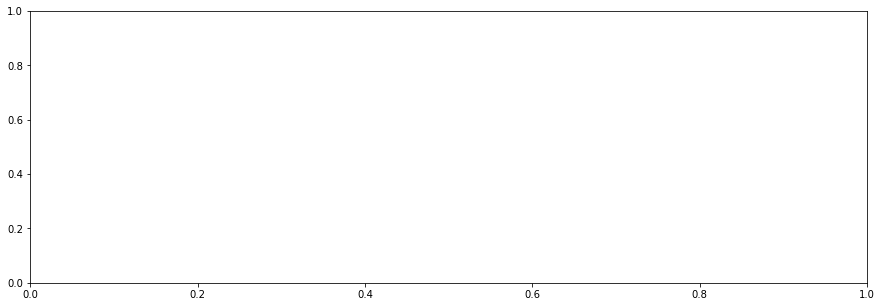

In [28]:

# plot
testCond_forplot = 'coop(1.5s)' # 'no-vision','self','coop(1s)'
# testCond_forplot = 'self' # 'no-vision','self','coop(1s)'
# ROC_summary_all_forplot = ROC_summary_all_merged[ROC_summary_all_merged['testCondition']==testCond_forplot]
ROC_summary_all_forplot = ROC_summary_all_mean[ROC_summary_all_mean['testCondition']==testCond_forplot]

# plot the summarizing figure - pool all animals together
#
fig2, axs2 = plt.subplots(1,1)
fig2.set_figheight(5)
fig2.set_figwidth(15)
# s=seaborn.barplot(ax=axs2,data=ROC_summary_all_forplot,x='action',y='predROC',hue='type',errorbar='ci',alpha=.5)
s=seaborn.boxplot(ax=axs2,data=ROC_summary_all_forplot,x='action',y='predROC',hue='type',whis=3)
# s=seaborn.swarmplot(ax=axs2,data=ROC_summary_all_forplot,x='action',y='predROC',hue='type',
#                   alpha=.9,size=6,dodge=True,legend=False)
plt.plot([-0.5,1.5],[0.5,0.5],'k--')
axs2.set_xlim([-0.5,1.5])
axs2.set_title('all animal')
s.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# plot the summarizing figure - separate each animal
#
fig3, axs3 = plt.subplots(2,1)
fig3.set_figheight(10)
fig3.set_figwidth(10)
#
events_forplot = ['pull','gaze'] 
nevents = np.shape(events_forplot)[0]

for ievent in np.arange(0,nevents,1):
    ievent_forplot = events_forplot[ievent]
    
    ROC_summary_all_ievent = ROC_summary_all_forplot[ROC_summary_all_forplot['action']==ievent_forplot]
    #
    s=seaborn.barplot(ax=axs3[ievent],data=ROC_summary_all_ievent,x='animal',y='predROC',hue='type',
                    errorbar='ci',alpha=.5)
    # s=seaborn.boxplot(ax=axs3[ievent],data=ROC_summary_all_ievent,x='animal',y='predROC',hue='type')
    # s=seaborn.swarmplot(ax=axs3[ievent],data=ROC_summary_all_ievent,x='animal',y='predROC',hue='type',
    #                   alpha=.9,size=6,dodge=True,legend=False)
    axs3[ievent].plot([-0.5,9.5],[0.5,0.5],'k--')
    axs3[ievent].set_xlim([-0.5,9.5])
    axs3[ievent].set_title('all animal; events of '+ievent_forplot)
    s.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
# plot the summarizing figure - separate male and female
maleanimals = np.array(['eddie','dannon','dodson','vermelho'])
allanimalnames = np.array(ROC_summary_all_forplot['animal'])
allanimalsexes = allanimalnames.copy()
#
allanimalsexes[np.isin(allanimalnames,maleanimals)]='male'
allanimalsexes[~np.isin(allanimalnames,maleanimals)]='female'
#
ROC_summary_all_forplot['sex'] = allanimalsexes

#
fig4, axs4 = plt.subplots(1,2)
fig4.set_figheight(5)
fig4.set_figwidth(20)
#
events_forplot = ['pull','gaze'] 
nevents = np.shape(events_forplot)[0]

for ievent in np.arange(0,nevents,1):
    ievent_forplot = events_forplot[ievent]
    
    ROC_summary_all_ievent = ROC_summary_all_forplot[ROC_summary_all_forplot['action']==ievent_forplot]
    #
    # s=seaborn.barplot(ax=axs4[ievent],data=ROC_summary_all_ievent,x='sex',y='predROC',hue='type',
    #                 errorbar='ci',alpha=.5)
    s=seaborn.boxplot(ax=axs4[ievent],data=ROC_summary_all_ievent,x='sex',y='predROC',hue='type',whis=3)
    # s=seaborn.swarmplot(ax=axs3[ievent],data=ROC_summary_all_ievent,x='animal',y='predROC',hue='type',
    #                   alpha=.9,size=6,dodge=True,legend=False)
    axs4[ievent].plot([-0.5,1.5],[0.5,0.5],'k--')
    axs4[ievent].set_xlim([-0.5,1.5])
    axs4[ievent].set_title('all animal; events of '+ievent_forplot)
    if ievent == nevents-1:
        s.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        axs4[ievent].legend([])

if 0:
    # plot the summarizing figure - only plot the speficified condition; plot all animals together
    fig5, axs5 = plt.subplots(1,1)
    fig5.set_figheight(5)
    fig5.set_figwidth(15)
    #
    testCond_forplot = 'coop(1s)' # 'no-vision','self','coop(1s)'
    # ROC_summary_all_forplot = ROC_summary_all_merged[ROC_summary_all_merged['testCondition']==testCond_forplot]
    ROC_summary_all_forplot = ROC_summary_all_mean[ROC_summary_all_mean['testCondition']==testCond_forplot]
    #
    plottypes = ['threeMains','sync_pulls','gaze_lead_pull','social_attention',
        'threeMains_withSelfEdge','sync_pulls_withSelfEdge','gaze_lead_pull_withSelfEdge','social_attention_withSelfEdge']
    ind_toplot = np.isin(ROC_summary_all_forplot['type'],plottypes)
    ROC_summary_all_forplot2 = ROC_summary_all_forplot[ind_toplot]

    # s=seaborn.barplot(ax=axs5,data=ROC_summary_all_forplot2,x='action',y='predROC',hue='type',errorbar='ci',alpha=.5)
    s=seaborn.boxplot(ax=axs5,data=ROC_summary_all_forplot2,x='action',y='predROC',hue='type',whis=3)
    # s=seaborn.swarmplot(ax=axs5,data=ROC_summary_all_forplot2,x='action',y='predROC',hue='type',
    #                   alpha=.9,size=6,dodge=True,legend=False)
    plt.plot([-0.5,1.5],[0.5,0.5],'k--')
    axs5.set_xlim([-0.5,1.5])
    axs5.set_title('all animal, compared with and without self edges')
    s.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
savefig = 1
if savefig:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    fig2.savefig(figsavefolder+'withinCondition_DBNpredicition_andHypotheticalDependencies_differenttimelag_'+testCond_forplot+'_summarizingplot_allanimals.pdf')
    fig3.savefig(figsavefolder+'withinCondition_DBNpredicition_andHypotheticalDependencies_differenttimelag_'+testCond_forplot+'_summarizingplot_eachanimals.pdf')
    fig4.savefig(figsavefolder+'withinCondition_DBNpredicition_andHypotheticalDependencies_differenttimelag_'+testCond_forplot+'_summarizingplot_malefemales.pdf')
    if 0:
        fig5.savefig(figsavefolder+'withinCondition_DBNpredicition_andHypotheticalDependencies_differenttimelag_'+testCond_forplot+'_summarizingplot_allanimals_withandwithoutselfedge.pdf')



#### plot, for multiple task condition, across multiple time lags

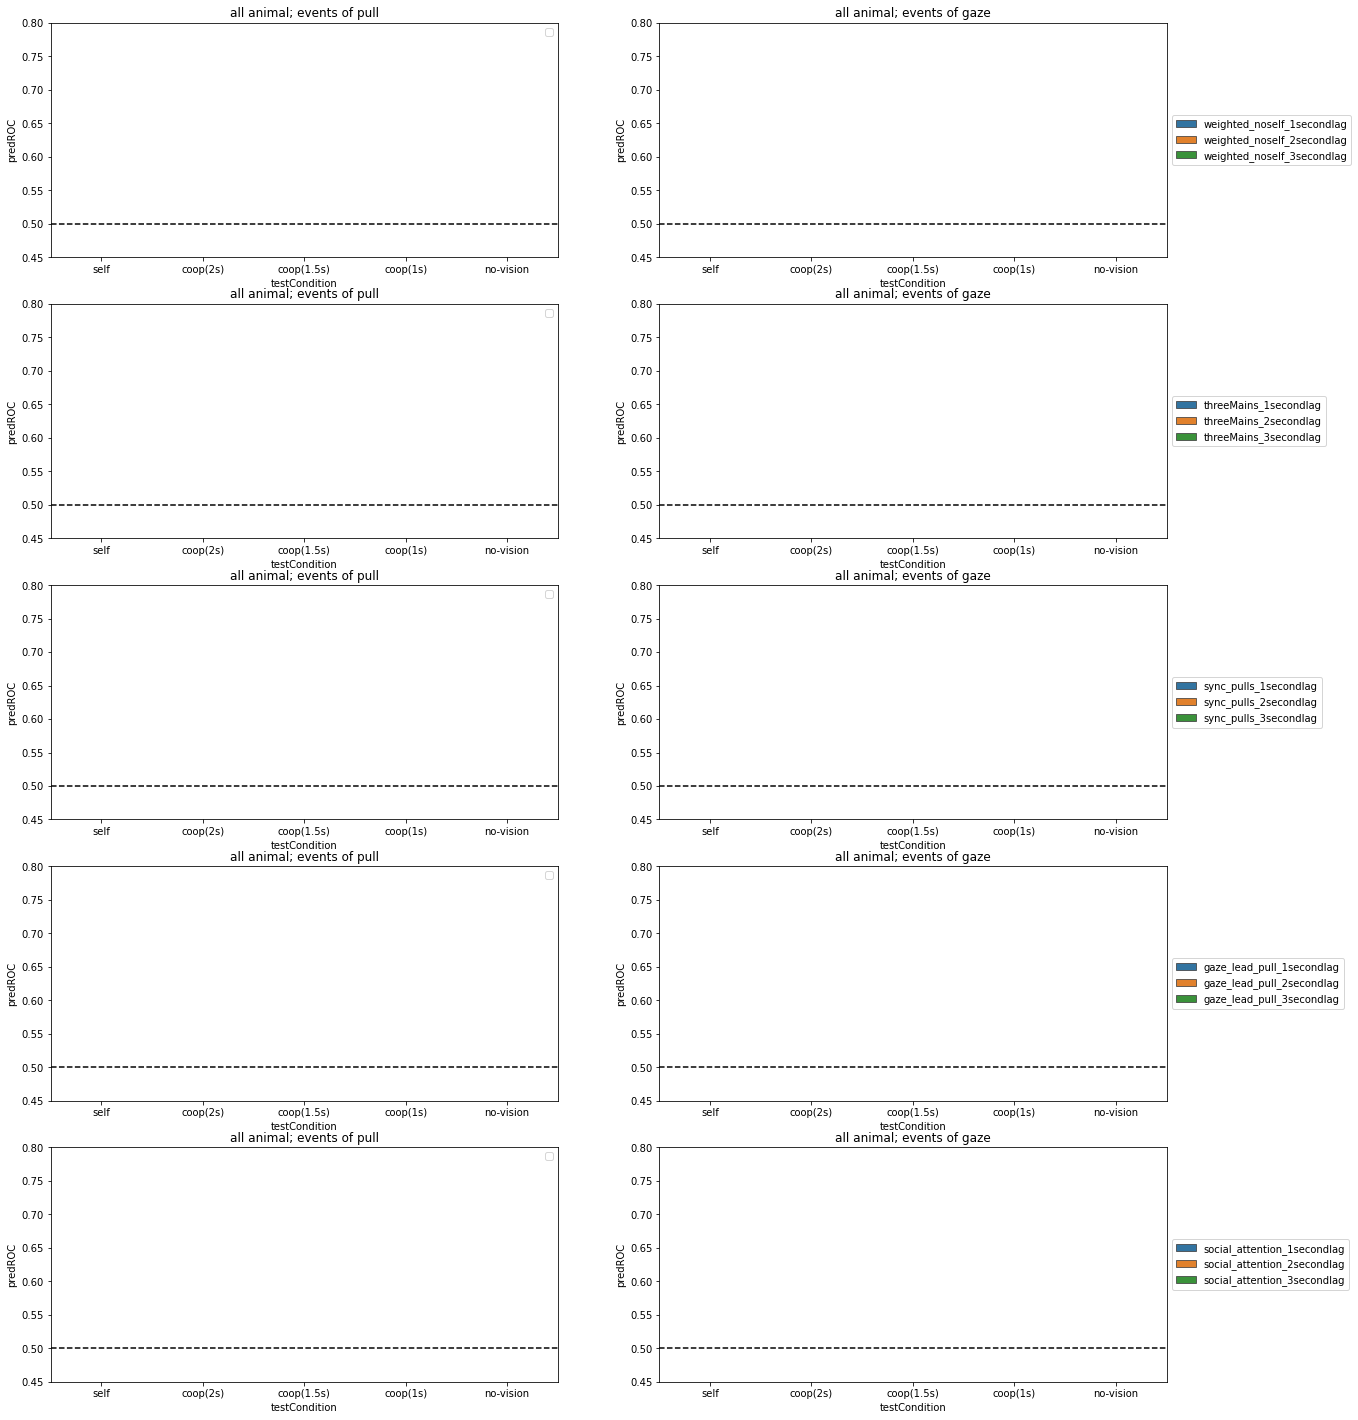

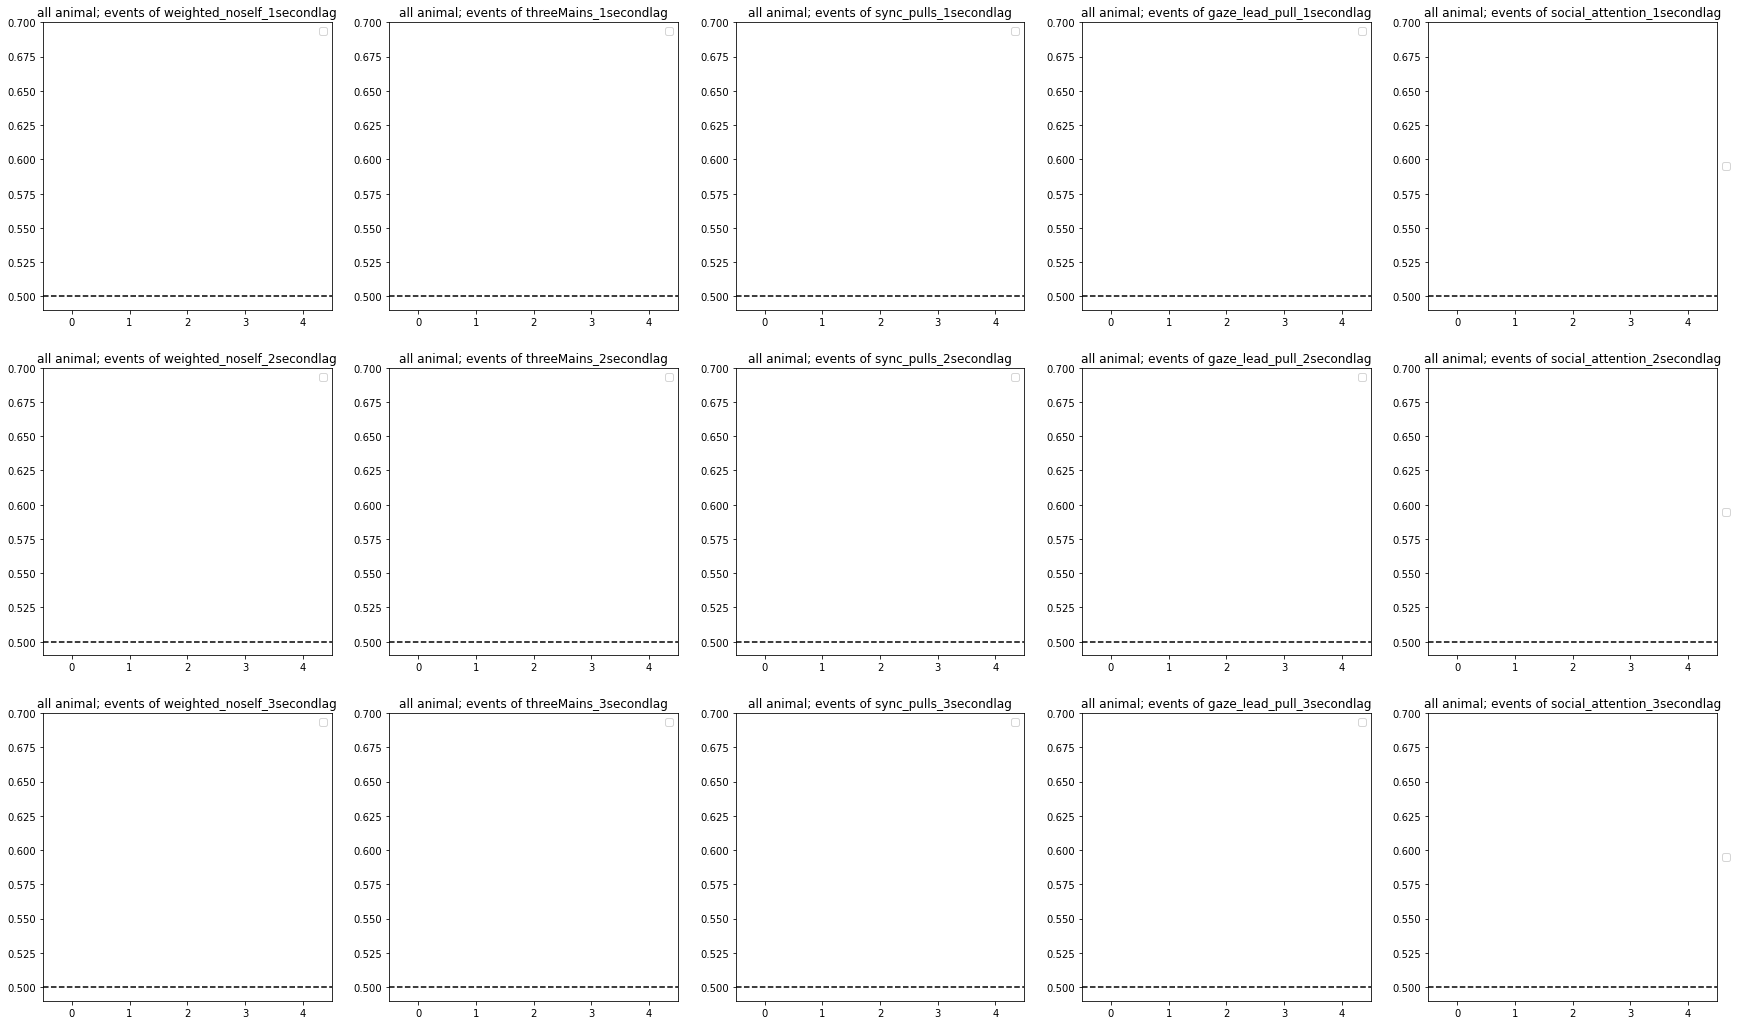

In [29]:
ROC_summary_all_forplot = ROC_summary_all_mean.copy()

taskconds_order = ['self','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
ROC_summary_all_forplot['testCondition'] = pd.Categorical(ROC_summary_all_forplot['testCondition'], 
                                                          categories=taskconds_order, ordered=True)
ROC_summary_all_forplot = ROC_summary_all_forplot.sort_values(by='testCondition')

#
events_forplot = ['pull','gaze'] 
nevents = np.shape(events_forplot)[0]

# 
# 
examinewithselfedge = 0
if examinewithselfedge:
    dependencies_forplot = ['weighted','threeMains_withSelfEdge','sync_pulls_withSelfEdge',
                            'gaze_lead_pull_withSelfEdge','social_attention_withSelfEdge']
else:
    dependencies_forplot = ['weighted_noself','threeMains','sync_pulls','gaze_lead_pull','social_attention']
    
ndepends = np.shape(dependencies_forplot)[0]


# separate the action and stretagy structure; box plot
fig4, axs4 = plt.subplots(ndepends,nevents)
fig4.set_figheight(5*ndepends)
fig4.set_figwidth(10*nevents)

for idepend in np.arange(0,ndepends,1):
    idepend_forplot = dependencies_forplot[idepend]
    
    idepend_alllags_forplot = [idepend_forplot+'_1secondlag',
                               idepend_forplot+'_2secondlag',
                               idepend_forplot+'_3secondlag',]
    
    
    ROC_summary_all_idepend = ROC_summary_all_forplot[np.isin(ROC_summary_all_forplot['type'],idepend_alllags_forplot)]
    ROC_summary_all_idepend['type'] = pd.Categorical(ROC_summary_all_idepend['type'],
                                                     categories = idepend_alllags_forplot, ordered=True)
    ROC_summary_all_idepend = ROC_summary_all_idepend.sort_values(by='type')
    
    
    for ievent in np.arange(0,nevents,1):
        ievent_forplot = events_forplot[ievent]

        ROC_summary_all_ievent = ROC_summary_all_idepend[ROC_summary_all_idepend['action']==ievent_forplot]
        #
        # s=seaborn.barplot(ax=axs4[idepend,ievent],data=ROC_summary_all_ievent,x='sex',y='predROC',hue='type',
        #                 errorbar='ci',alpha=.5)
        s=seaborn.boxplot(ax=axs4[idepend,ievent],data=ROC_summary_all_ievent,
                          x='testCondition',y='predROC',hue='type',whis=3)
        # s=seaborn.swarmplot(ax=axs3[idepend,ievent],data=ROC_summary_all_ievent,x='animal',y='predROC',hue='type',
        #                   alpha=.9,size=6,dodge=True,legend=False)
        # s=seaborn.lineplot(ax=axs4[idepend,ievent],data=ROC_summary_all_ievent,
        #                   x='testCondition',y='predROC',hue='type')
        axs4[idepend,ievent].plot([-0.5,4.5],[0.5,0.5],'k--')
        axs4[idepend,ievent].set_xlim([-0.5,4.5])
        axs4[idepend,ievent].set_ylim([0.45,0.8])
        axs4[idepend,ievent].set_title('all animal; events of '+ievent_forplot)
        if ievent == nevents-1:
            s.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            axs4[idepend,ievent].legend([])
            
        if 0:
            # Connect the same individuals with lines across categories
            x_ticks_offset = [-0.33,0,0.33]
            linecolors = ['b','r','g']
            for animal in ROC_summary_all_idepend['animal'].unique():
                individual_data = ROC_summary_all_ievent[ROC_summary_all_idepend['animal'] == animal]
                
                types_toplot = np.unique(individual_data['type'])
                ntypes = np.shape(types_toplot)[0]
                
                for itype in np.arange(0,ntypes,1):
                    indidivual_data_itype = individual_data[individual_data['type']==types_toplot[itype]]
                
                    indidivual_data_itype['testCondition'] = pd.Categorical(indidivual_data_itype['testCondition'], 
                                                          categories=taskconds_order, ordered=True)
                    indidivual_data_itype =indidivual_data_itype.sort_values(by='testCondition')
                
                    xxx = axs4[idepend,ievent].get_xticks()
                    xticklabels = axs4[idepend,ievent].get_xticklabels()
                    xtick_labels_text = [label.get_text() for label in xticklabels]
                    nticks = np.shape(xtick_labels_text)[0]
                    #
                    xxx_toplots = np.zeros(np.shape(indidivual_data_itype['testCondition']))
                    #
                    for itick in np.arange(0,nticks,1):
                        indd = np.array(indidivual_data_itype['testCondition']) == xtick_labels_text[itick]
                        xxx_toplots[indd] = xxx[itick]
                                       
                    
                    axs4[idepend,ievent].plot(xxx_toplots+x_ticks_offset[itype], indidivual_data_itype['predROC'],
                                              '-', color=linecolors[itype])



# separate the dependency structures and time lags, similar to the DBN fitting summarizing results; line plot
timelags_forplot = ['1secondlag','2secondlag','3secondlag']
nlags = np.shape(timelags_forplot)[0]
fig5, axs5 = plt.subplots(nlags,ndepends)
fig5.set_figheight(6*nlags)
fig5.set_figwidth(6*ndepends)
     
for idepend in np.arange(0,ndepends,1):
    idepend_forplot = dependencies_forplot[idepend]
    
    for ilag in np.arange(0,nlags,1):
        ilag_forplot = timelags_forplot[ilag]
        
        idepend_ilag_forplot = idepend_forplot+'_'+ilag_forplot

        ROC_summary_all_idepend_ilag = ROC_summary_all_forplot[np.isin(ROC_summary_all_forplot['type'],idepend_ilag_forplot)]
        ROC_summary_all_idepend_ilag['action'] = pd.Categorical(ROC_summary_all_idepend_ilag['action'],
                                                     categories = events_forplot, ordered=True)
        ROC_summary_all_idepend_ilag = ROC_summary_all_idepend_ilag.sort_values(by='action')
        
        
        s=seaborn.lineplot(ax=axs5[ilag,idepend],data=ROC_summary_all_idepend_ilag,
                          x='testCondition',y='predROC',hue='action')
        axs5[ilag,idepend].plot([-0.5,4.5],[0.5,0.5],'k--')
        axs5[ilag,idepend].set_xlim([-0.5,4.5])
        axs5[ilag,idepend].set_ylim([0.49,0.7])
        axs5[ilag,idepend].set_title('all animal; events of '+idepend_ilag_forplot)
        if idepend == ndepends-1:
            s.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            axs5[ilag,idepend].legend([])
        
savefig = 1
if savefig:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions_succpull/'+savefile_sufix+'/'+cameraID+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    if examinewithselfedge:
        fig4.savefig(figsavefolder+'withinCondition_DBNpredicition_andHypotheticalDependencies_withselfedge_differenttimelag_multiconditions_summarizingplot.pdf')
        fig5.savefig(figsavefolder+'withinCondition_DBNpredicition_andHypotheticalDependencies_withselfedge_differenttimelag_multiconditions_summarizingplot_lineplot.pdf')       
    else:
        fig4.savefig(figsavefolder+'withinCondition_DBNpredicition_andHypotheticalDependencies_noselfedge_differenttimelag_multiconditions_summarizingplot.pdf')
        fig5.savefig(figsavefolder+'withinCondition_DBNpredicition_andHypotheticalDependencies_noselfedge_differenttimelag_multiconditions_summarizingplot_lineplot.pdf')
